In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 44.9 MB/s eta 0:00:00


In [3]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import fitz  # PyMuPDF for PDF handling
import re  # For regular expressions
import os  # For file handling
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display


In [10]:
import fitz  # PyMuPDF
import re

def extract_toc_from_first_pages(pdf_path, toc_start_page=0, toc_end_page=10):
    """Extract the Table of Contents manually by reading the first few pages."""
    toc_text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page_num in range(toc_start_page, toc_end_page):
                page_text = doc.load_page(page_num).get_text()
                toc_text += page_text
    except Exception as e:
        print(f"Error reading the PDF file for TOC: {e}")
    return toc_text

# Path to your PDF file
pdf_path = '/content/drive/MyDrive/practice-standard-project-risk-management.pdf'

# Extract TOC from the first 10 pages (you can adjust the range)
toc_text = extract_toc_from_first_pages(pdf_path, toc_start_page=0, toc_end_page=10)

# Display extracted TOC text
print("Extracted TOC Text:", toc_text)


Extracted TOC Text:  Project Management Institute 
 PRACTICE STANDARD 
FOR PROJECT RISK MANAGEMENT 
 ISBN: 978-1-933890-38-8 
 Published by: 
 
Project Management Institute, Inc. 
 
14 Campus Boulevard 
 
Newtown Square, Pennsylvania 19073-3299 USA. 
 
Phone: +610-356-4600 
 
Fax: +610-356-4647 
 
E-mail: customercare@pmi.org 
 Internet: www.pmi.org 
 ©2009 Project Management Institute, Inc. All rights reserved. 
 “PMI”, the PMI logo, “PMP”, the PMP logo, “PMBOK”, “PgMP”, “Project Management Journal”, “PM Network”, and the PMI 
Today logo are registered marks of Project Management Institute, Inc. The Quarter Globe Design is a trademark of the Project 
Management Institute, Inc. For a comprehensive list of PMI marks, contact the PMI Legal Department. 
 PMI Publications welcomes corrections and comments on its books. Please feel free to send comments on typographical, 
formatting, or other errors. Simply make a copy of the relevant page of the book, mark the error, and send it to: Book E

In [14]:
def parse_toc(toc_text):
    """Parse the Table of Contents text to extract section titles and page numbers."""
    sections = []
    lines = toc_text.split('\n')

    # Simple regex to capture titles followed by a page number
    for line in lines:
        match = re.match(r'(.*?)(\d+)$', line.strip())  # Captures the title and the page number
        if match:
            section_title = match.group(1).strip()
            page_number = int(match.group(2).strip())
            sections.append((section_title, page_number))

    return sections

# Parse the TOC text to get chapter titles and page numbers
toc_entries = parse_toc(toc_text)

# Display parsed TOC entries
print("Parsed TOC Entries:", toc_entries)


Parsed TOC Entries: [('ISBN: 978-1-933890-38-', 8), ('Phone: +610-356-', 4600), ('Fax: +610-356-', 4647), ('Fax: +1-770-280-', 4113), ('10  9  8  7  6  5  4  3  2', 1), ('Cert no. SW-COC-', 1530), ('CHAPTER 1 -  INTRODUCTION ...................................................................................................', 1), ('1.1 Purpose of the Practice Standard for Project Risk Management  ..........................', 2), ('1.2 Project Risk Management Deﬁ nition  ......................................................................', 4), ('1.3 Role of Project Risk Management in Project Management ...................................', 4), ('1.4 Good Risk Management Practice ............................................................................', 5), ('1.5 Critical Success Factors for Project Risk Management .........................................', 6), ('1.6 Conclusion  .......................................................................................................

In [15]:
import re

def clean_toc(toc_entries):
    """Remove unwanted TOC entries like ISBNs, phone numbers, etc."""
    cleaned_toc = []
    for title, page_num in toc_entries:
        # Remove entries that match unwanted patterns like ISBN, phone, fax, etc.
        if not re.search(r'ISBN|Phone|Fax|Cert|(\d\s+\d\s+\d)', title):
            cleaned_toc.append((title, page_num))

    return cleaned_toc

# Assuming toc_entries has already been extracted and parsed
toc_entries = clean_toc(toc_entries)
print("Cleaned TOC Entries:", toc_entries)


Cleaned TOC Entries: [('CHAPTER 1 -  INTRODUCTION ...................................................................................................', 1), ('1.1 Purpose of the Practice Standard for Project Risk Management  ..........................', 2), ('1.2 Project Risk Management Deﬁ nition  ......................................................................', 4), ('1.3 Role of Project Risk Management in Project Management ...................................', 4), ('1.4 Good Risk Management Practice ............................................................................', 5), ('1.5 Critical Success Factors for Project Risk Management .........................................', 6), ('1.6 Conclusion  ...............................................................................................................', 7), ('CHAPTER 2 -  PRINCIPLES AND CONCEPTS ..............................................................................', 9), ('2.1 Introduction .................

In [16]:
def clean_text(text):
    """Clean the text by removing unwanted patterns."""
    # Remove phone numbers, ISBNs, references, and common unwanted patterns
    text = re.sub(r'ISBN[-:\d\s]+', '', text)  # Remove ISBN
    text = re.sub(r'Phone:\s*[+\d\s-]+', '', text)  # Remove phone numbers
    text = re.sub(r'Fax:\s*[+\d\s-]+', '', text)  # Remove fax numbers
    text = re.sub(r'\d\s+\d\s+\d\s+\d', '', text)  # Remove sequences like '10 9 8 7 6 5 4 3 2'
    text = re.sub(r'Cert no\.\s*[A-Z0-9-]+', '', text)  # Remove certificate numbers
    text = re.sub(r'References', '', text, flags=re.I)  # Remove references section if present

    # Optionally remove other known unwanted content
    # You can adjust this based on the patterns you observe in the document
    return text

def extract_chapter_texts(pdf_path, toc_entries):
    """Extract and clean chapter texts based on TOC entries."""
    chapter_texts = []
    with fitz.open(pdf_path) as doc:
        total_pages = doc.page_count

        for i, (title, start_page) in enumerate(toc_entries):
            print(f"Extracting text for chapter: {title}, starting at page {start_page}")

            if i < len(toc_entries) - 1:
                end_page = toc_entries[i + 1][1]  # Next chapter's starting page
            else:
                end_page = total_pages  # Last chapter goes to the end of the document

            # Extract text from the start page to the page before the next chapter
            chapter_text = ""
            for page_num in range(start_page - 1, end_page - 1):  # PyMuPDF uses 0-indexed pages
                page = doc.load_page(page_num)
                chapter_text += page.get_text()

            # Clean the extracted chapter text
            chapter_text = clean_text(chapter_text)

            print(f"Extracted and cleaned {len(chapter_text)} characters for chapter: {title}")
            chapter_texts.append((title, chapter_text))

    return chapter_texts

# Step 2: Extract and clean texts for each chapter
chapter_texts = extract_chapter_texts(pdf_path, toc_entries)

# Create a DataFrame
df = pd.DataFrame(chapter_texts, columns=["Chapter", "Text"])

# Display the DataFrame
print(df.head())


Extracting text for chapter: CHAPTER 1 -  INTRODUCTION ..................................................................................................., starting at page 1
Extracted and cleaned 80 characters for chapter: CHAPTER 1 -  INTRODUCTION ...................................................................................................
Extracting text for chapter: 1.1 Purpose of the Practice Standard for Project Risk Management  .........................., starting at page 2
Extracted and cleaned 4142 characters for chapter: 1.1 Purpose of the Practice Standard for Project Risk Management  ..........................
Extracting text for chapter: 1.2 Project Risk Management Deﬁ nition  ......................................................................, starting at page 4
Extracted and cleaned 0 characters for chapter: 1.2 Project Risk Management Deﬁ nition  ......................................................................
Extracting text for chapter: 1.3 Role of Proj

In [17]:
import re

def split_into_sentences(text):
    """Split text into sentences using punctuation."""
    # Regular expression to split text by sentence-ending punctuation
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Splits on punctuation followed by space
    sentences = [s.strip() for s in sentences if s]  # Clean up spaces and empty strings
    return sentences

def extract_and_split_chapter_texts(pdf_path, toc_entries):
    """Extract chapter texts based on TOC entries and split them into sentences."""
    chapter_sentences = []
    with fitz.open(pdf_path) as doc:
        total_pages = doc.page_count

        for i, (title, start_page) in enumerate(toc_entries):
            print(f"Extracting text for chapter: {title}, starting at page {start_page}")

            if i < len(toc_entries) - 1:
                end_page = toc_entries[i + 1][1]  # Next chapter's starting page
            else:
                end_page = total_pages  # Last chapter goes to the end of the document

            # Extract text from the start page to the page before the next chapter
            chapter_text = ""
            for page_num in range(start_page - 1, end_page - 1):  # PyMuPDF uses 0-indexed pages
                page = doc.load_page(page_num)
                chapter_text += page.get_text()

            # Clean the extracted chapter text
            chapter_text = clean_text(chapter_text)

            # Split the chapter text into sentences
            sentences = split_into_sentences(chapter_text)

            print(f"Extracted and split into {len(sentences)} sentences for chapter: {title}")
            chapter_sentences.append((title, sentences))

    return chapter_sentences

# Step 2: Extract, clean, and split texts for each chapter into sentences
chapter_sentences = extract_and_split_chapter_texts(pdf_path, toc_entries)

# Convert chapter sentences into a pandas DataFrame
df_sentences = pd.DataFrame([(chapter, sentence) for chapter, sentences in chapter_sentences for sentence in sentences], columns=["Chapter", "Sentence"])

# Display the DataFrame
print(df_sentences.head())




Extracting text for chapter: CHAPTER 1 -  INTRODUCTION ..................................................................................................., starting at page 1
Extracted and split into 1 sentences for chapter: CHAPTER 1 -  INTRODUCTION ...................................................................................................
Extracting text for chapter: 1.1 Purpose of the Practice Standard for Project Risk Management  .........................., starting at page 2
Extracted and split into 29 sentences for chapter: 1.1 Purpose of the Practice Standard for Project Risk Management  ..........................
Extracting text for chapter: 1.2 Project Risk Management Deﬁ nition  ......................................................................, starting at page 4
Extracted and split into 0 sentences for chapter: 1.2 Project Risk Management Deﬁ nition  ......................................................................
Extracting text for chapter: 1.3 Role of P

In [19]:
!pip install nltk spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords and punkt tokenizer if not already available
nltk.download('stopwords')
nltk.download('punkt')

# Load the spacy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_sentence(sentence):
    """Preprocess a sentence by applying lowercasing, removing punctuation, stopwords, and lemmatization."""
    # Lowercase the sentence
    sentence = sentence.lower()

    # Tokenize the sentence
    words = word_tokenize(sentence)

    # Remove punctuation and stopwords, and apply lemmatization
    cleaned_words = []
    for word in words:
        if word not in string.punctuation and word not in stop_words:
            # Lemmatize the word using spacy
            doc = nlp(word)
            lemma = doc[0].lemma_
            cleaned_words.append(lemma)

    return ' '.join(cleaned_words)  # Join the processed words back into a sentence

# Example usage on a list of sentences
def preprocess_sentences(df):
    """Apply preprocessing to all sentences in the DataFrame."""
    df['Processed Sentence'] = df['Sentence'].apply(preprocess_sentence)
    return df

# Step 3: Apply preprocessing to the DataFrame
df_sentences = preprocess_sentences(df_sentences)

# Display the processed sentences
print(df_sentences[['Chapter', 'Sentence', 'Processed Sentence']].head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                             Chapter  \
0  CHAPTER 1 -  INTRODUCTION .......................   
1  1.1 Purpose of the Practice Standard for Proje...   
2  1.1 Purpose of the Practice Standard for Proje...   
3  1.1 Purpose of the Practice Standard for Proje...   
4  1.1 Purpose of the Practice Standard for Proje...   

                                            Sentence  \
0  Project Management Institute \n PRACTICE STAND...   
1  Published by: \n \nProject Management Institut...   
2  14 Campus Boulevard \n \nNewtown Square, Penns...   
3  E-mail: customercare@pmi.org \n Internet: www....   
4                               All rights reserved.   

                                  Processed Sentence  
0  project management institute practice standard...  
1           publish project management institute inc  
2  14 campus boulevard newtown square pennsylvani...  
3  e customercare pmi.org internet www.pmi.org © ...  
4                                      right reserv

In [21]:
df_sentences[['Chapter', 'Sentence', 'Processed Sentence']].head()

Chapter  \
0  CHAPTER 1 -  INTRODUCTION .......................   
1  1.1 Purpose of the Practice Standard for Proje...   
2  1.1 Purpose of the Practice Standard for Proje...   
3  1.1 Purpose of the Practice Standard for Proje...   
4  1.1 Purpose of the Practice Standard for Proje...   

                                            Sentence  \
0  Project Management Institute \n PRACTICE STAND...   
1  Published by: \n \nProject Management Institut...   
2  14 Campus Boulevard \n \nNewtown Square, Penns...   
3  E-mail: customercare@pmi.org \n Internet: www....   
4                               All rights reserved.   

                                  Processed Sentence  
0  project management institute practice standard...  
1           publish project management institute inc  
2  14 campus boulevard newtown square pennsylvani...  
3  e customercare pmi.org internet www.pmi.org © ...  
4                                      right reserve

In [22]:
def extract_nouns_verbs(sentence):
    """Extract nouns and verbs from a sentence."""
    doc = nlp(sentence)
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    return nouns, verbs

# Apply the function to each sentence
def calculate_pos_proportions(df):
    """Calculate the proportion of nouns and verbs in each sentence."""
    noun_counts = []
    verb_counts = []
    total_words = []

    for sentence in df['Processed Sentence']:
        nouns, verbs = extract_nouns_verbs(sentence)
        total_tokens = len(sentence.split())

        noun_counts.append(len(nouns))
        verb_counts.append(len(verbs))
        total_words.append(total_tokens)

    df['Noun Count'] = noun_counts
    df['Verb Count'] = verb_counts
    df['Total Words'] = total_words
    df['Noun Proportion'] = df['Noun Count'] / df['Total Words']
    df['Verb Proportion'] = df['Verb Count'] / df['Total Words']

    return df

# Step 2: Apply to your DataFrame
df_sentences = calculate_pos_proportions(df_sentences)

# Display the updated DataFrame
df_sentences[['Chapter', 'Processed Sentence', 'Noun Proportion', 'Verb Proportion']].head()

Chapter  \
0  CHAPTER 1 -  INTRODUCTION .......................   
1  1.1 Purpose of the Practice Standard for Proje...   
2  1.1 Purpose of the Practice Standard for Proje...   
3  1.1 Purpose of the Practice Standard for Proje...   
4  1.1 Purpose of the Practice Standard for Proje...   

                                  Processed Sentence  Noun Proportion  \
0  project management institute practice standard...            0.375   
1           publish project management institute inc            0.000   
2  14 campus boulevard newtown square pennsylvani...            0.250   
3  e customercare pmi.org internet www.pmi.org © ...            0.200   
4                                      right reserve            0.000   

   Verb Proportion  
0              0.0  
1              0.0  
2              0.0  
3              0.1  
4              0.0

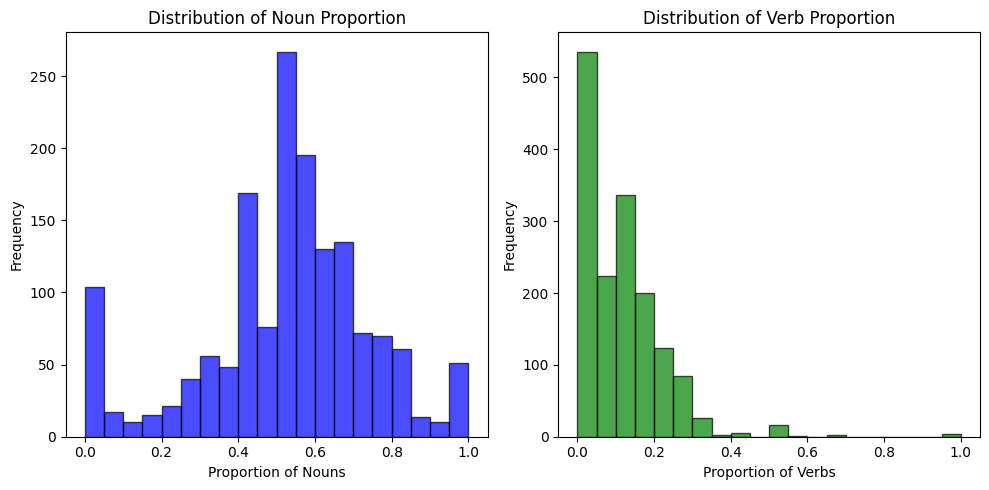

In [23]:
import matplotlib.pyplot as plt

# Plot histogram of Noun and Verb Proportions
plt.figure(figsize=(10, 5))

# Noun Proportion
plt.subplot(1, 2, 1)
plt.hist(df_sentences['Noun Proportion'].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Noun Proportion')
plt.xlabel('Proportion of Nouns')
plt.ylabel('Frequency')

# Verb Proportion
plt.subplot(1, 2, 2)
plt.hist(df_sentences['Verb Proportion'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Verb Proportion')
plt.xlabel('Proportion of Verbs')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


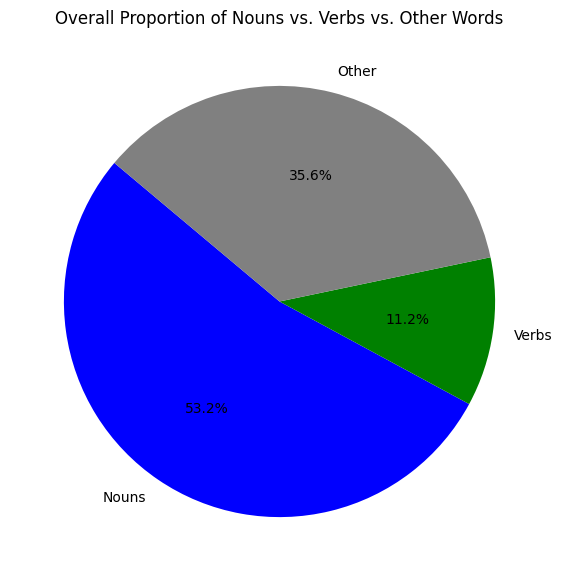

In [25]:
# Sum of all nouns and verbs across the dataset
total_nouns = df_sentences['Noun Count'].sum()
total_verbs = df_sentences['Verb Count'].sum()
total_words = df_sentences['Total Words'].sum()

# Calculate proportions
noun_verb_data = [total_nouns, total_verbs, total_words - total_nouns - total_verbs]
labels = ['Nouns', 'Verbs', 'Other']

# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(noun_verb_data, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'gray'], startangle=140)
plt.title('Overall Proportion of Nouns vs. Verbs vs. Other Words')
plt.show()


In [26]:
from collections import Counter

# Get all nouns and verbs from the dataset
all_nouns = sum(df_sentences['Processed Sentence'].apply(lambda x: extract_nouns_verbs(x)[0]), [])
all_verbs = sum(df_sentences['Processed Sentence'].apply(lambda x: extract_nouns_verbs(x)[1]), [])

# Find the most common nouns and verbs
noun_freq = Counter(all_nouns).most_common(10)
verb_freq = Counter(all_verbs).most_common(10)

print("Most common nouns:", noun_freq)
print("Most common verbs:", verb_freq)


Most common nouns: [('risk', 1672), ('project', 1134), ('management', 604), ('process', 299), ('plan', 263), ('analysis', 256), ('response', 244), ('technique', 150), ('action', 118), ('chapter', 117)]
Most common verbs: [('practice', 128), ('identify', 101), ('use', 88), ('include', 82), ('perform', 81), ('require', 81), ('provide', 74), ('occur', 66), ('see', 46), ('ensure', 45)]


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def combine_sentences_by_chapter(df):
    """Combine the processed sentences by chapter to treat each chapter as a document."""
    chapter_texts = df.groupby('Chapter')['Processed Sentence'].apply(lambda x: ' '.join(x)).reset_index()
    return chapter_texts

# Step 1: Combine the processed sentences for each chapter
df_chapter_texts = combine_sentences_by_chapter(df_sentences)

# Step 2: Apply TF-IDF to the combined chapter texts
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_chapter_texts['Processed Sentence'])

# Step 3: Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df_chapter_texts['Chapter'], columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame (showing first few rows)
print(tfidf_df.head())

# Step 4: Display the top 10 words with the highest TF-IDF score in each chapter
for chapter in tfidf_df.index:
    print(f"Top words in {chapter}:")
    top_words = tfidf_df.loc[chapter].sort_values(ascending=False).head(10)
    print(top_words)
    print("\n")


                                                    0317        10  100  \
Chapter                                                                   
1.1 Purpose of the Practice Standard for Projec...   0.0  0.000000  0.0   
1.4 Good Risk Management Practice ................   0.0  0.122123  0.0   
1.5 Critical Success Factors for Project Risk M...   0.0  0.050855  0.0   
1.6 Conclusion  ..................................   0.0  0.000000  0.0   
2.2 Deﬁ nition of Project Risk ...................   0.0  0.000000  0.0   

                                                         101  102  103  104  \
Chapter                                                                       
1.1 Purpose of the Practice Standard for Projec...  0.000000  0.0  0.0  0.0   
1.4 Good Risk Management Practice ................  0.000000  0.0  0.0  0.0   
1.5 Critical Success Factors for Project Risk M...  0.000000  0.0  0.0  0.0   
1.6 Conclusion  ..................................  0.000000  0.0  0.0  0.0   


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def combine_sentences_by_chapter(df):
    """Combine the processed sentences by chapter to treat each chapter as a document."""
    chapter_texts = df.groupby('Chapter')['Processed Sentence'].apply(lambda x: ' '.join(x)).reset_index()
    return chapter_texts

# Step 1: Combine the processed sentences for each chapter
df_chapter_texts = combine_sentences_by_chapter(df_sentences)

# Step 2: Apply TF-IDF with N-Grams (bigrams and trigrams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3))  # Extract bigrams and trigrams
tfidf_matrix = tfidf_vectorizer.fit_transform(df_chapter_texts['Processed Sentence'])

# Step 3: Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df_chapter_texts['Chapter'], columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame (showing first few rows)
print(tfidf_df.head())

# Step 4: Display the top 10 N-Grams with the highest TF-IDF score in each chapter
for chapter in tfidf_df.index:
    print(f"Top N-Grams in {chapter}:")
    top_ngrams = tfidf_df.loc[chapter].sort_values(ascending=False).head(10)
    print(top_ngrams)
    print("\n")


                                                    0317 project  \
Chapter                                                            
1.1 Purpose of the Practice Standard for Projec...           0.0   
1.4 Good Risk Management Practice ................           0.0   
1.5 Critical Success Factors for Project Risk M...           0.0   
1.6 Conclusion  ..................................           0.0   
2.2 Deﬁ nition of Project Risk ...................           0.0   

                                                    0317 project management  \
Chapter                                                                       
1.1 Purpose of the Practice Standard for Projec...                      0.0   
1.4 Good Risk Management Practice ................                      0.0   
1.5 Critical Success Factors for Project Risk M...                      0.0   
1.6 Conclusion  ..................................                      0.0   
2.2 Deﬁ nition of Project Risk ..................

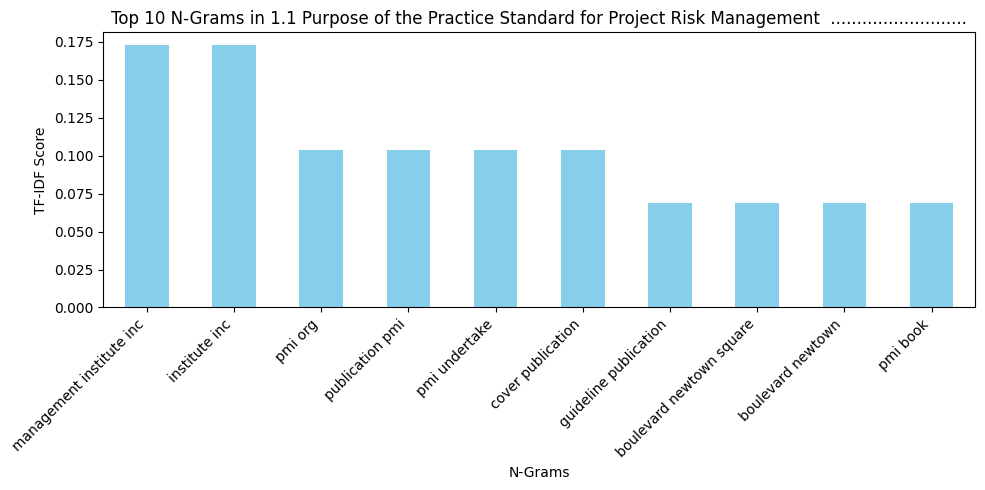

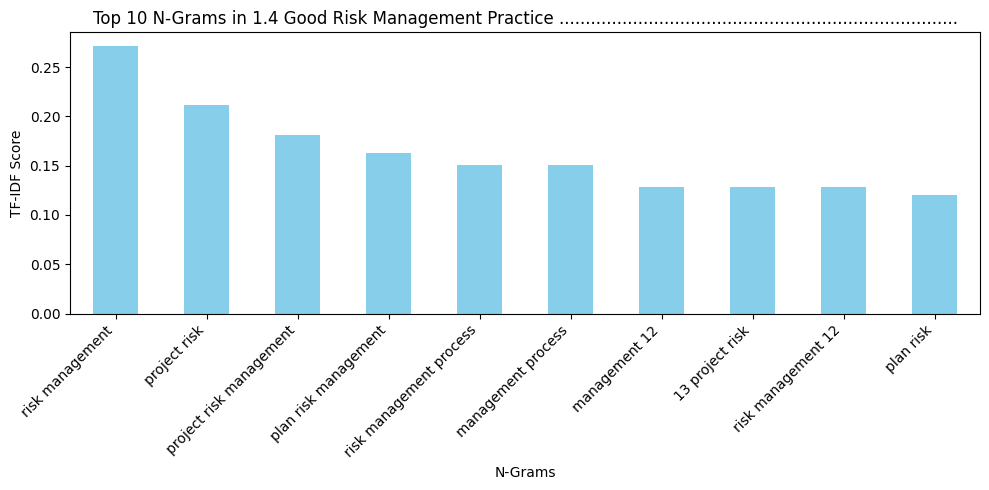

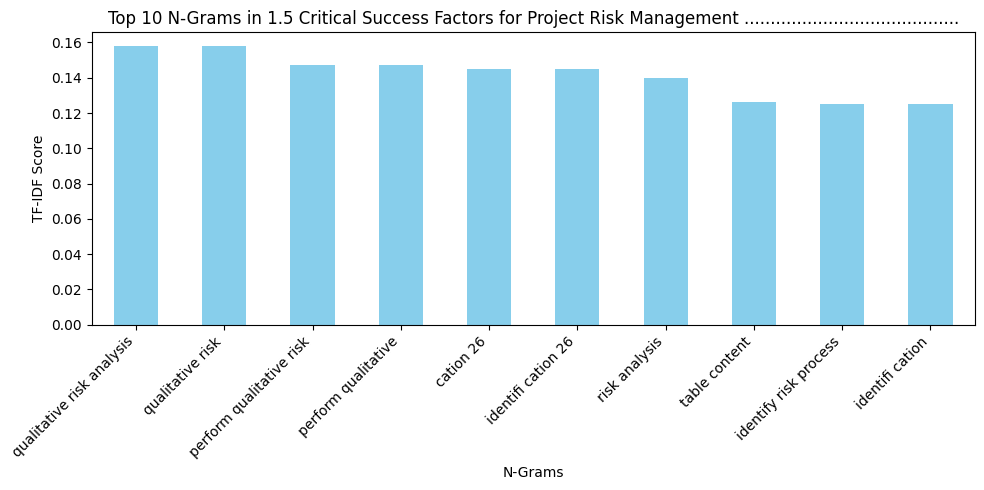

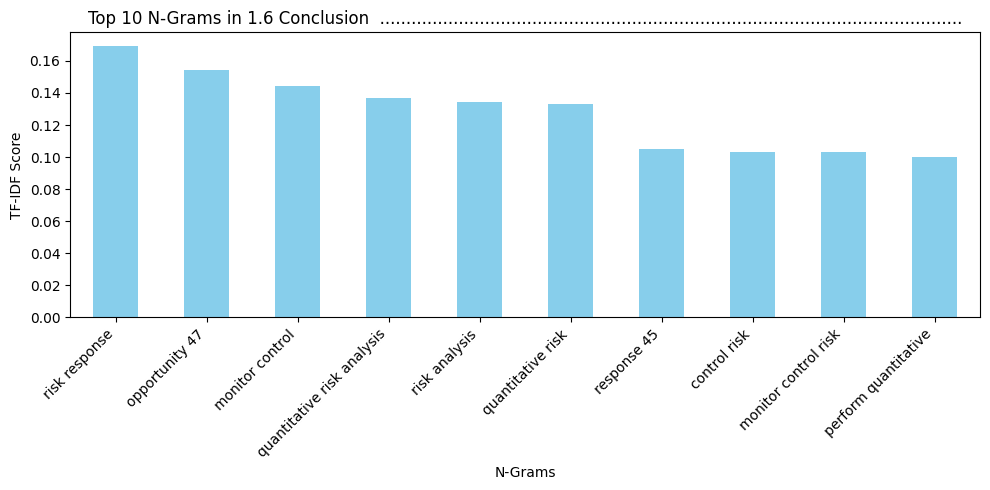

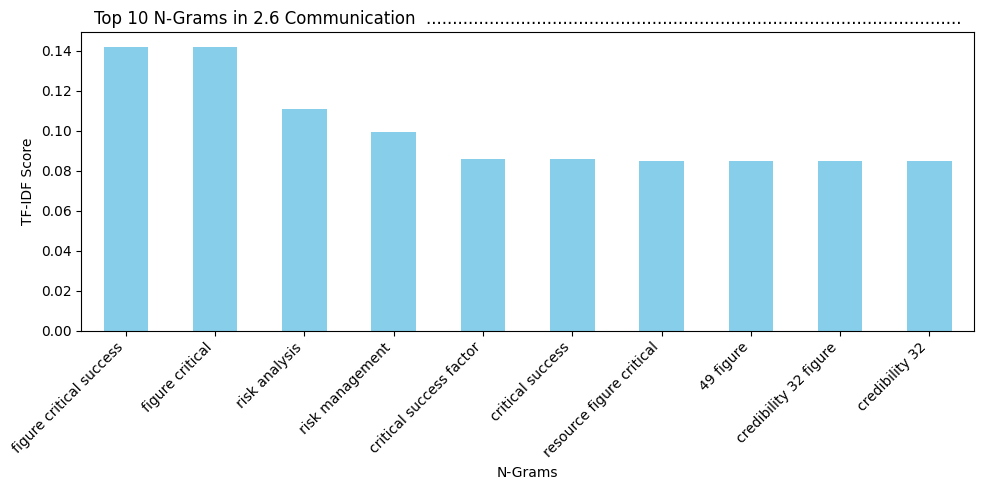

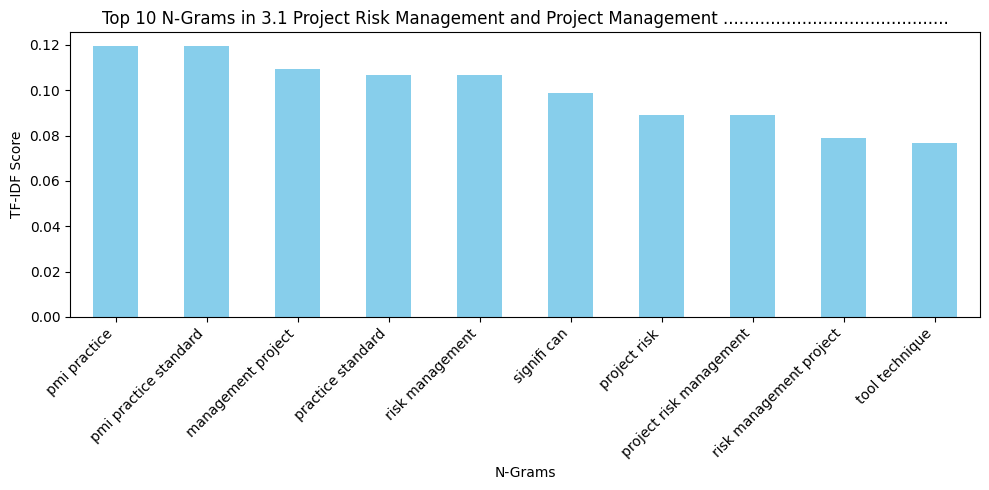

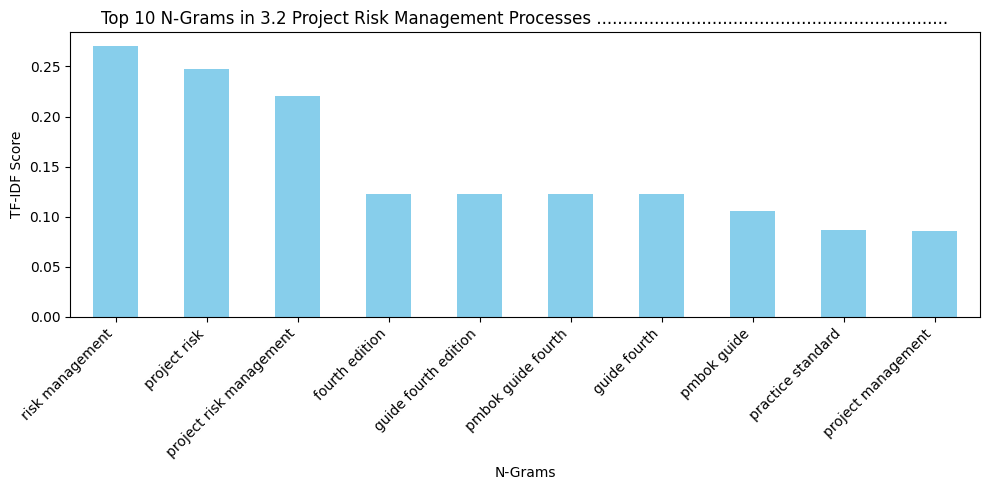

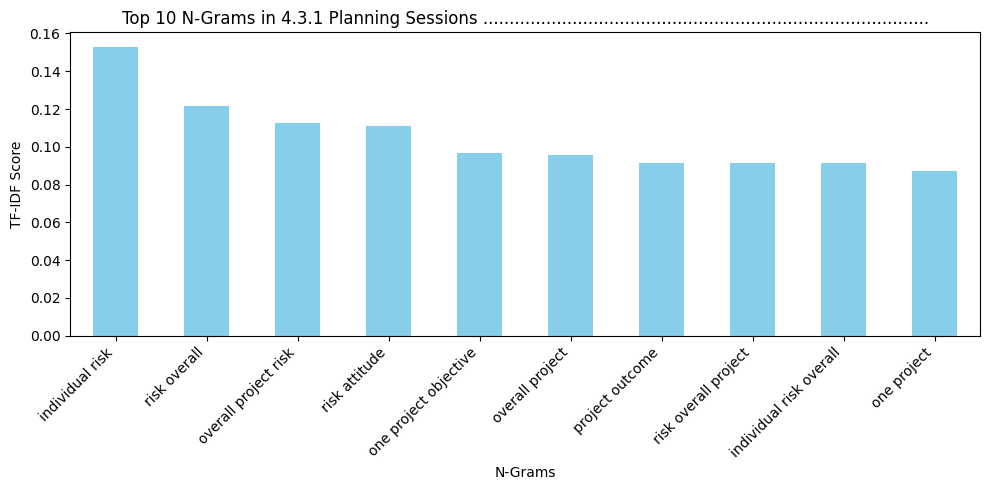

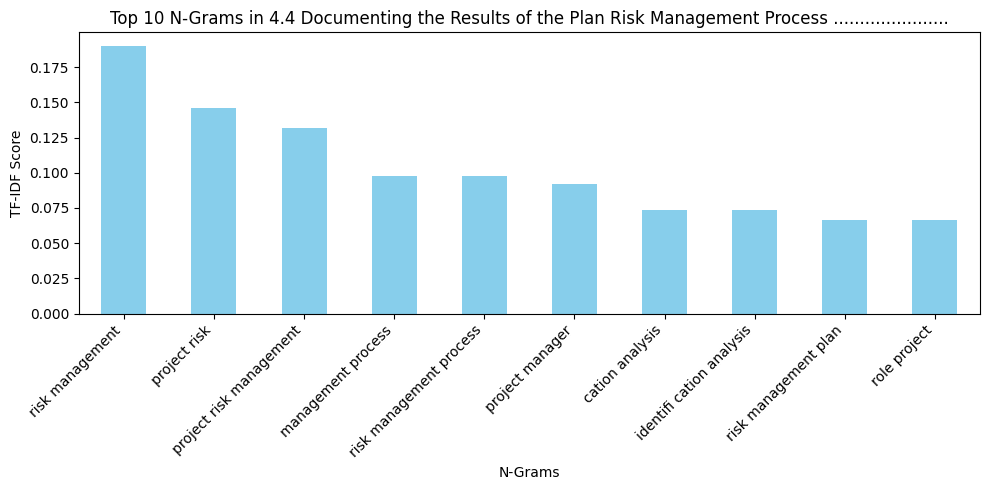

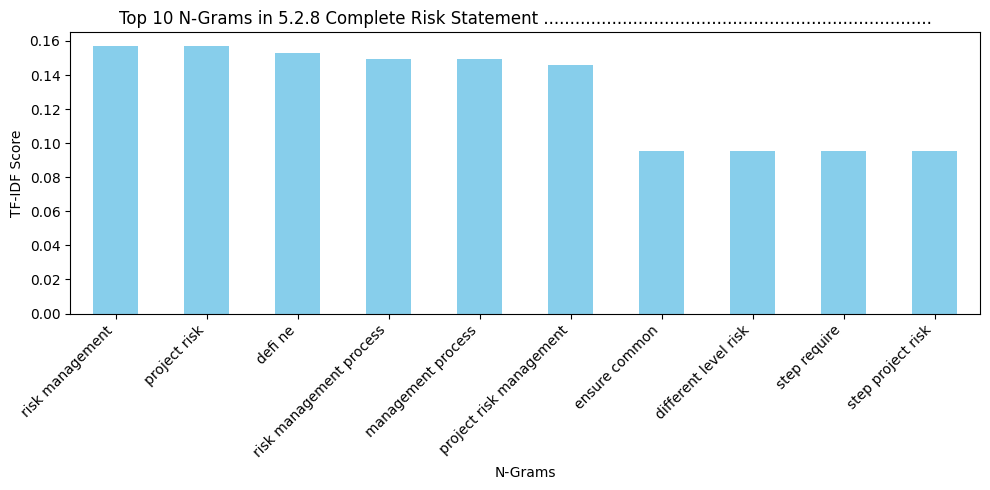

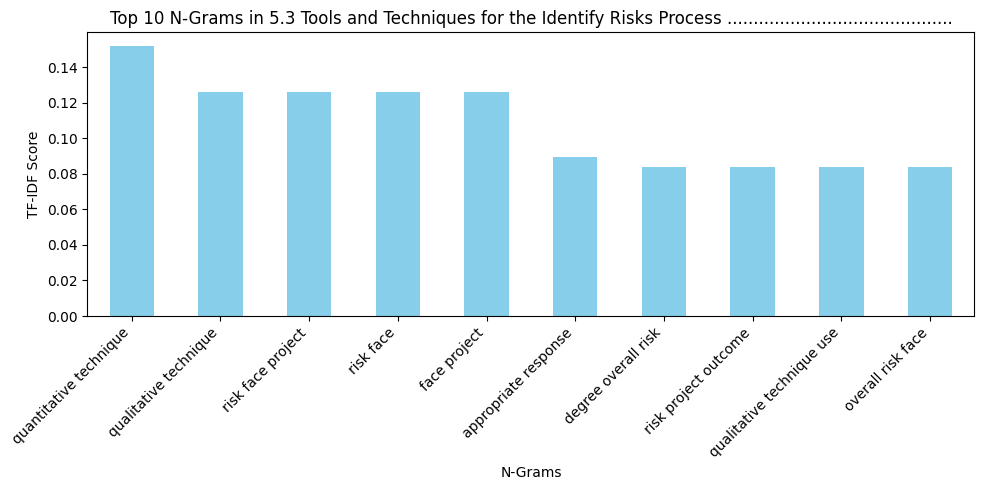

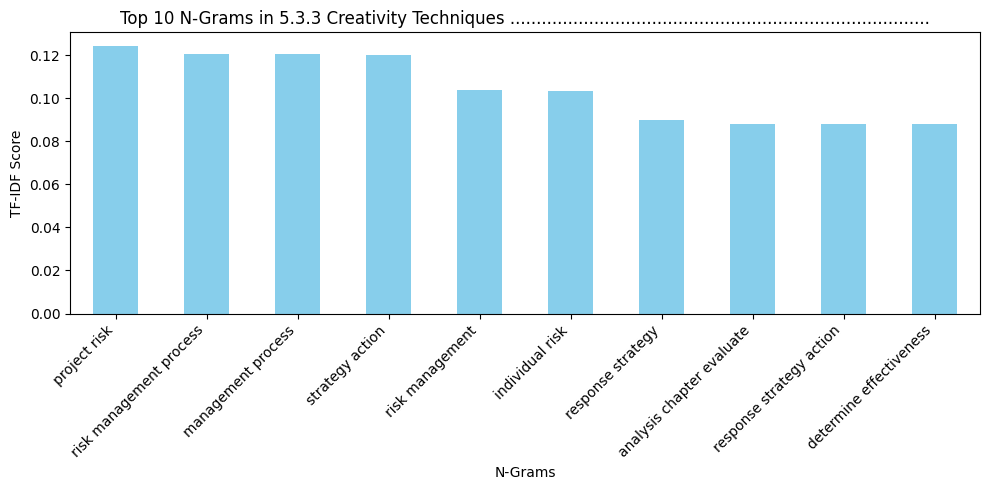

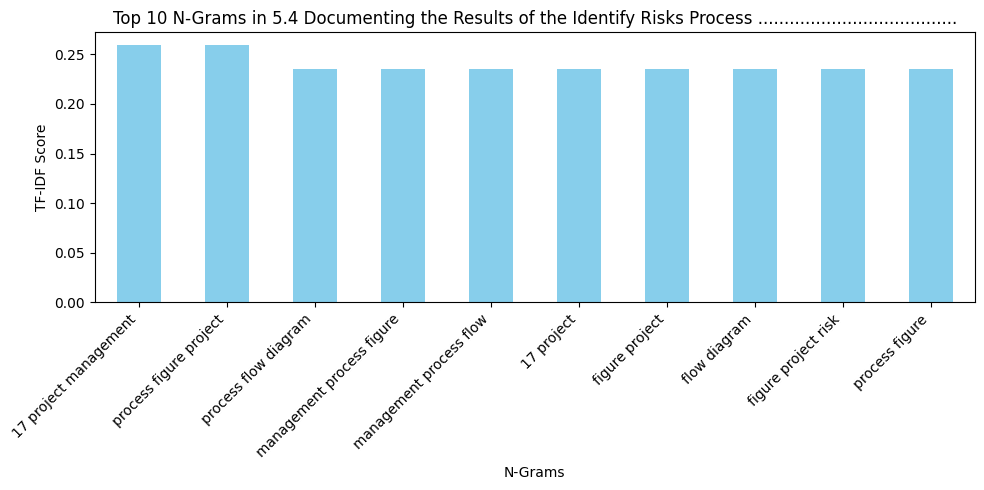

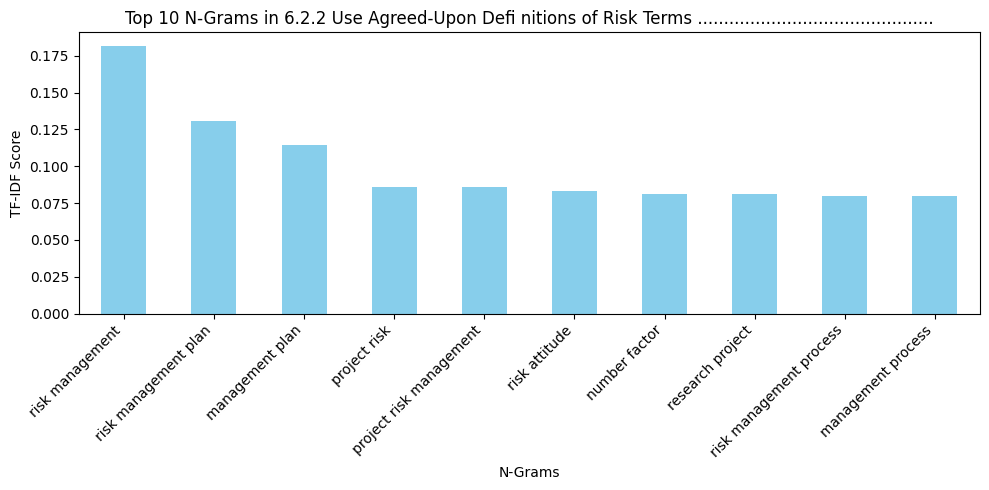

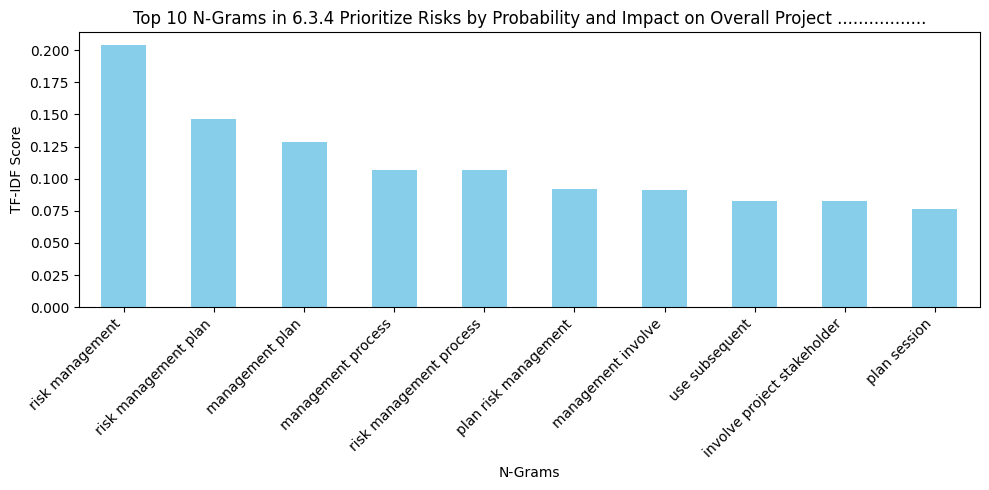

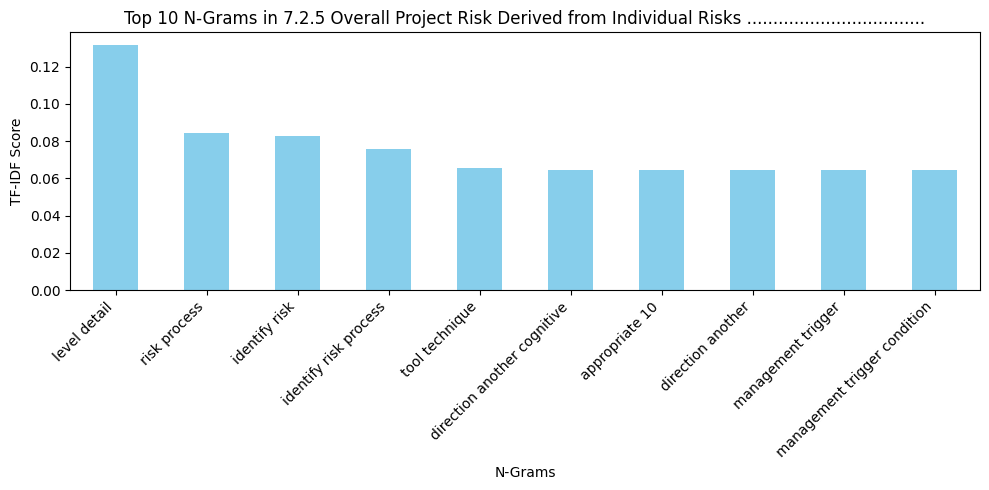

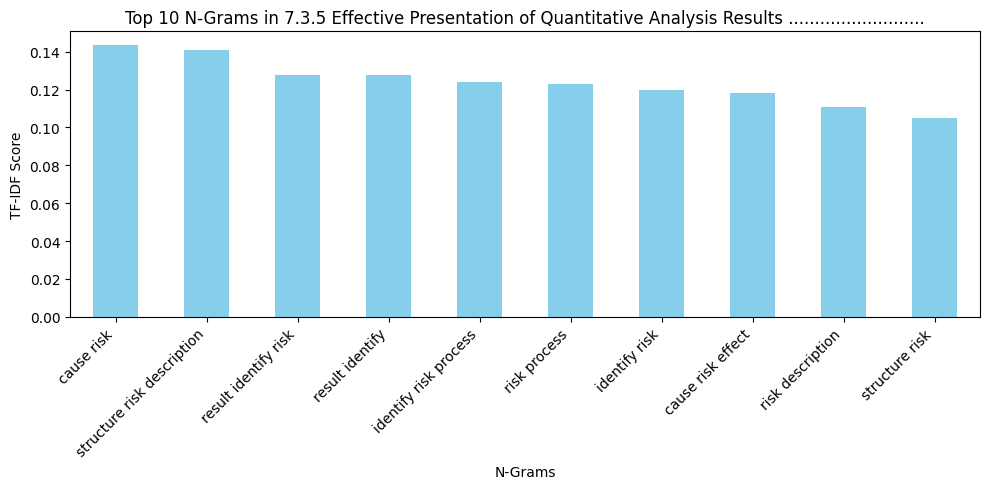

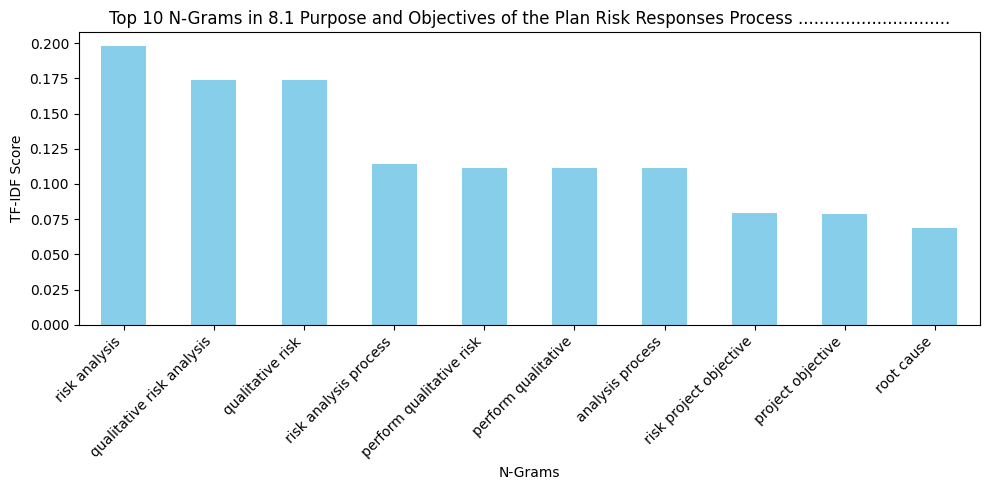

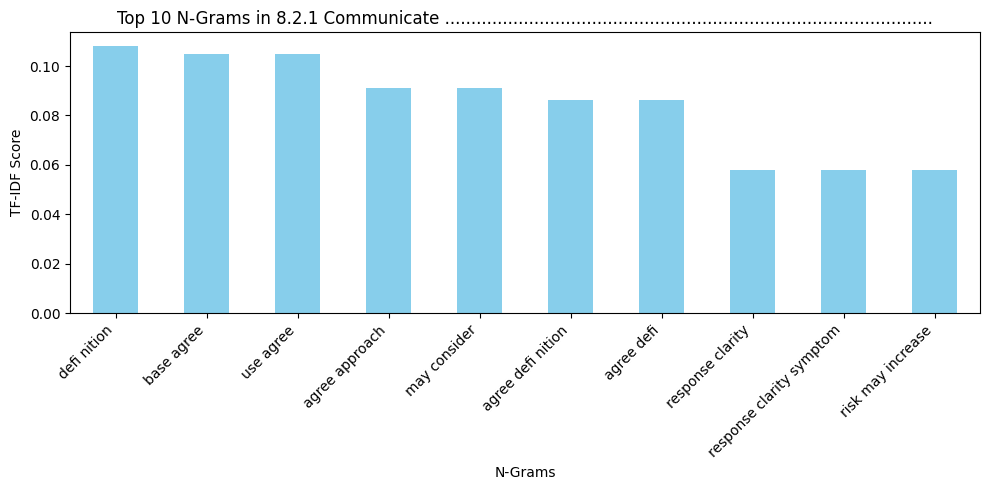

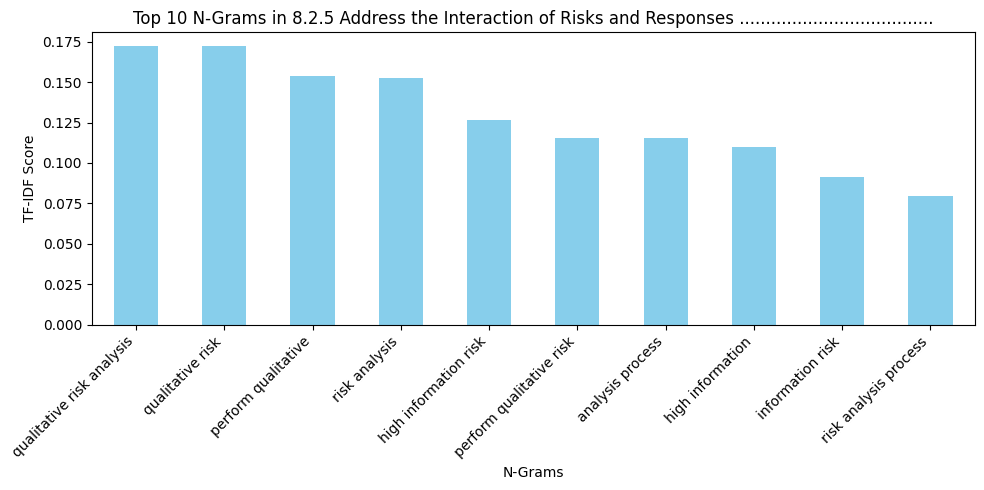

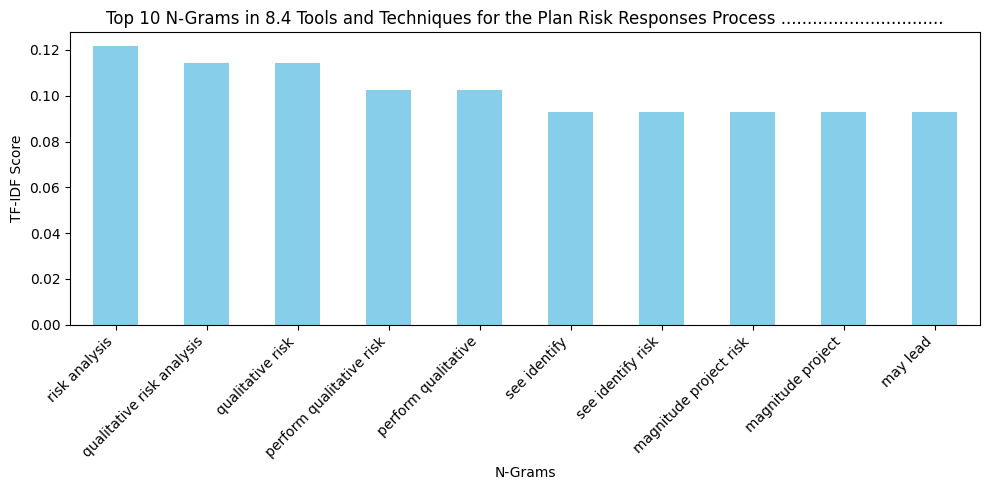

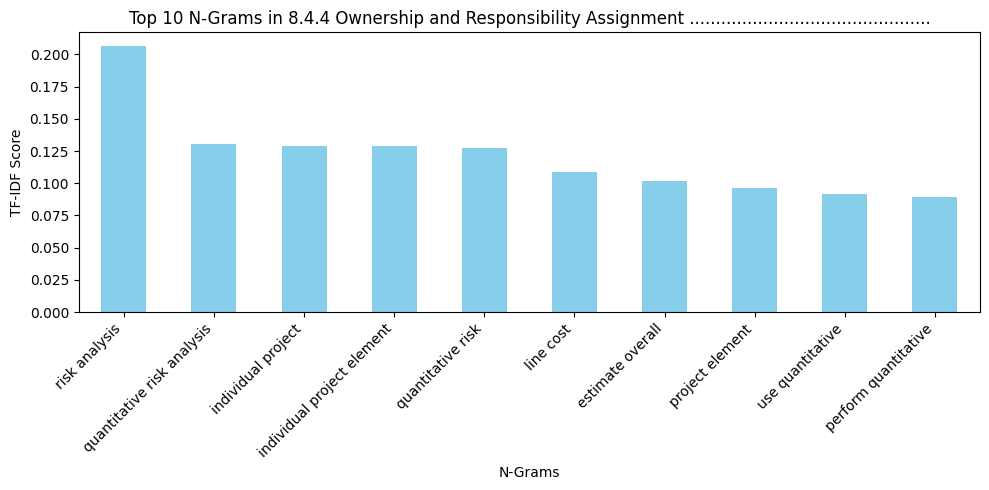

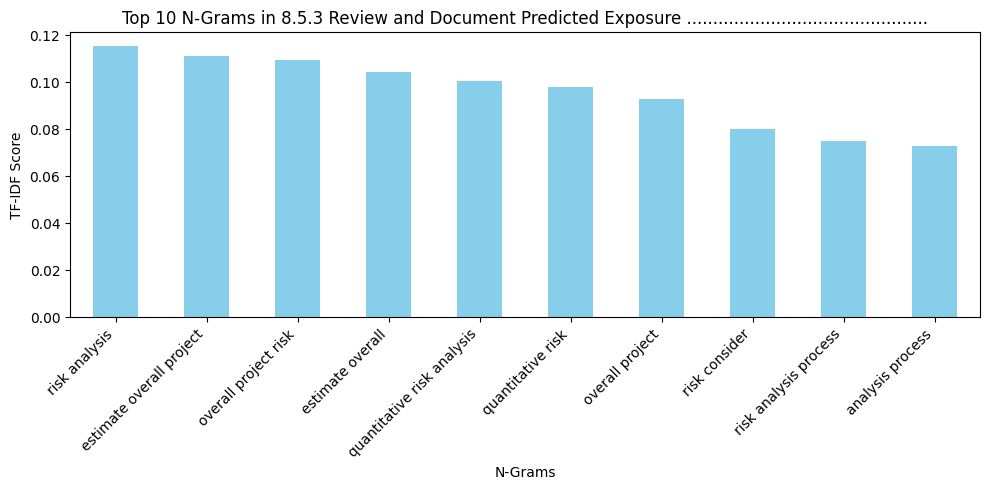

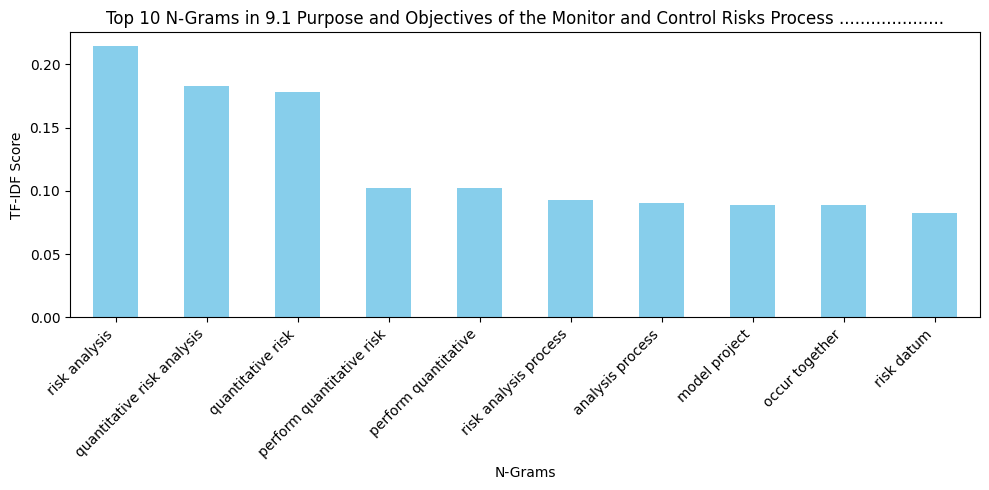

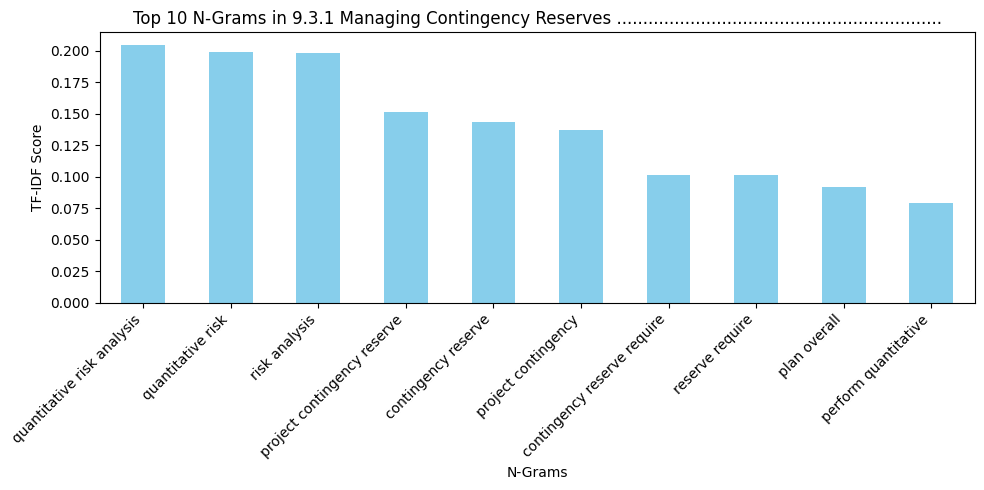

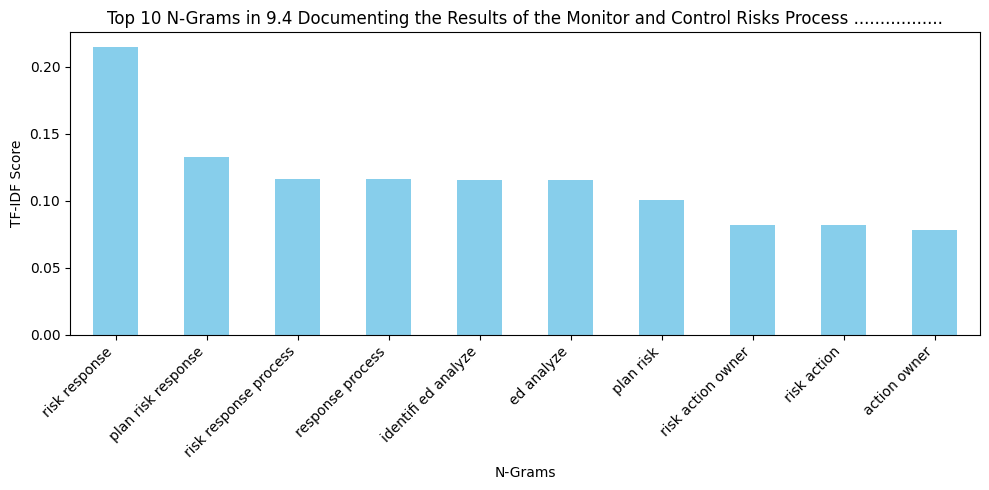

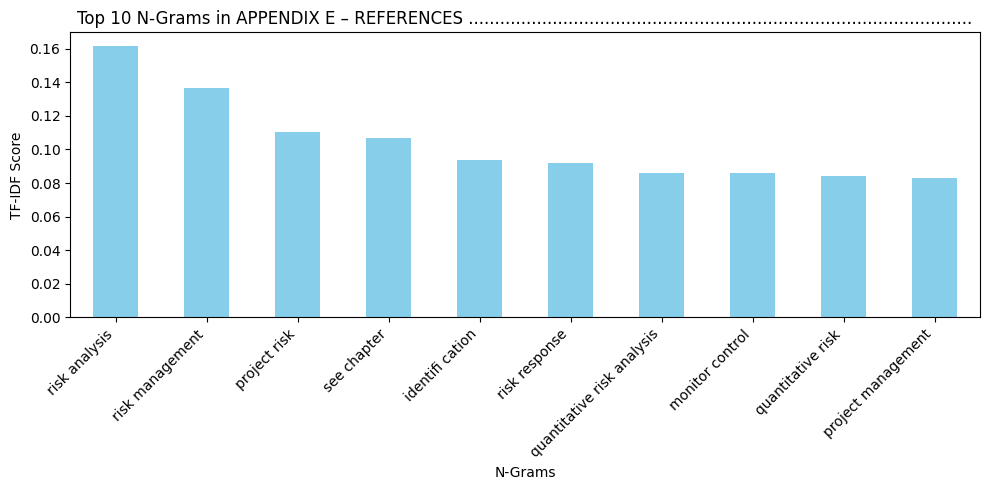

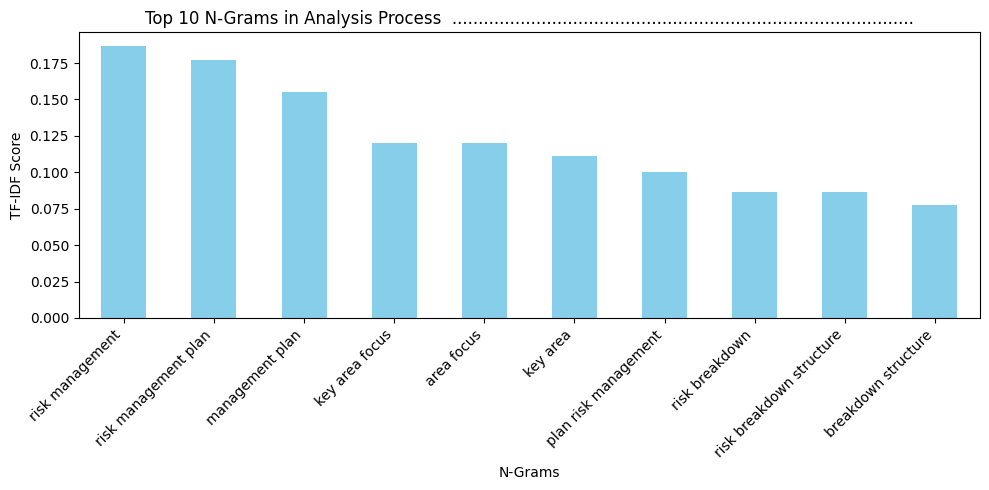

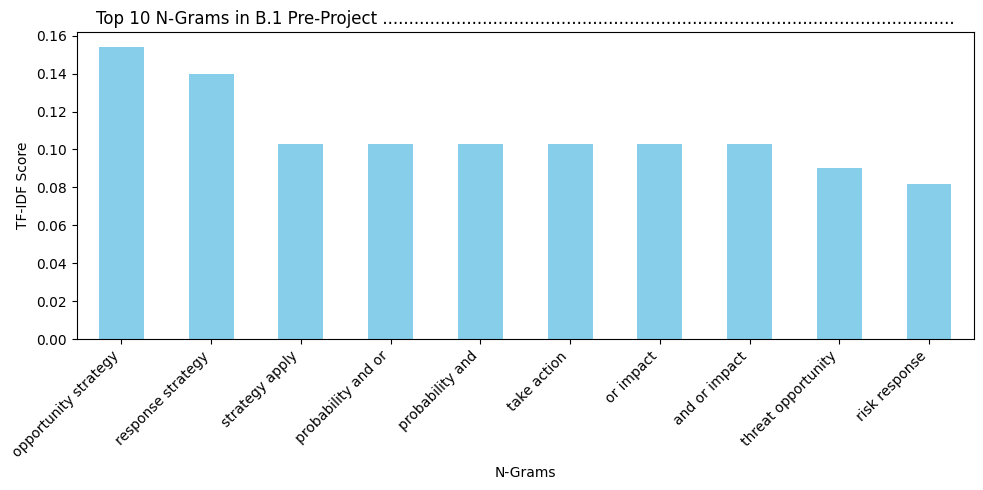

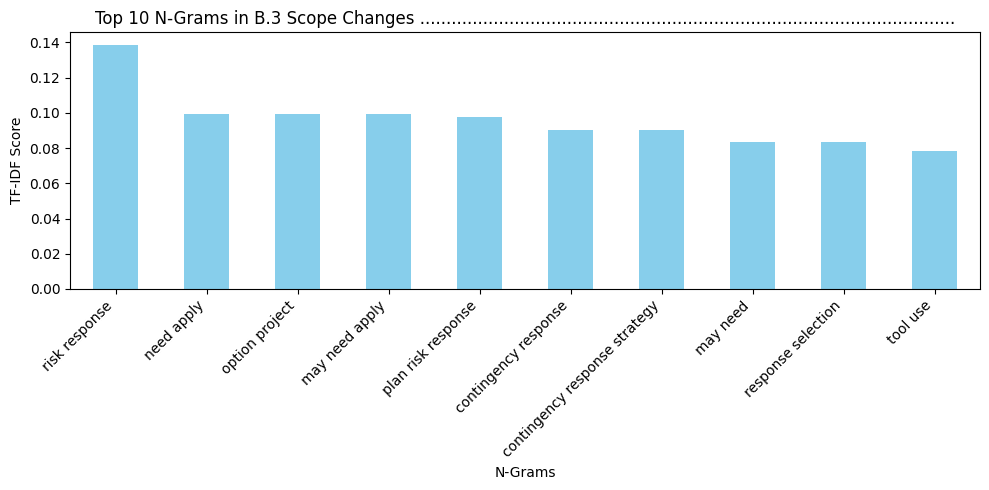

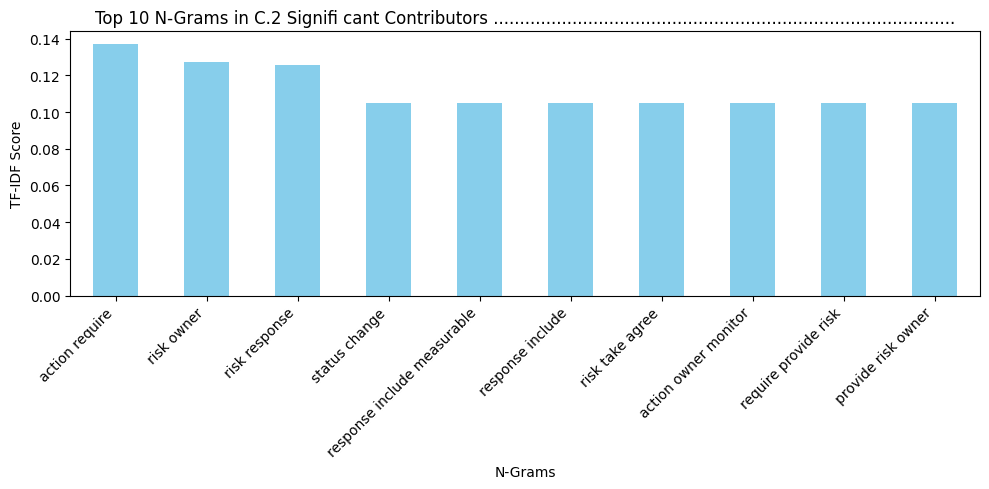

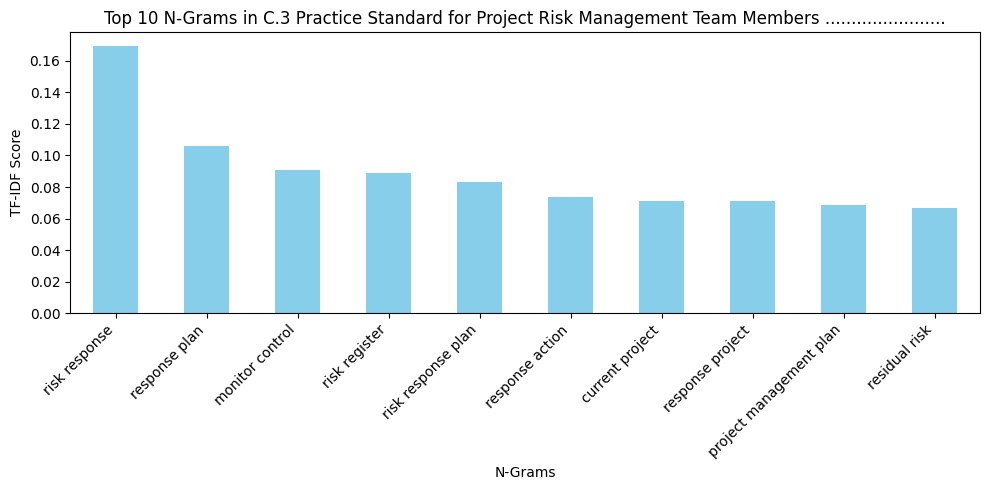

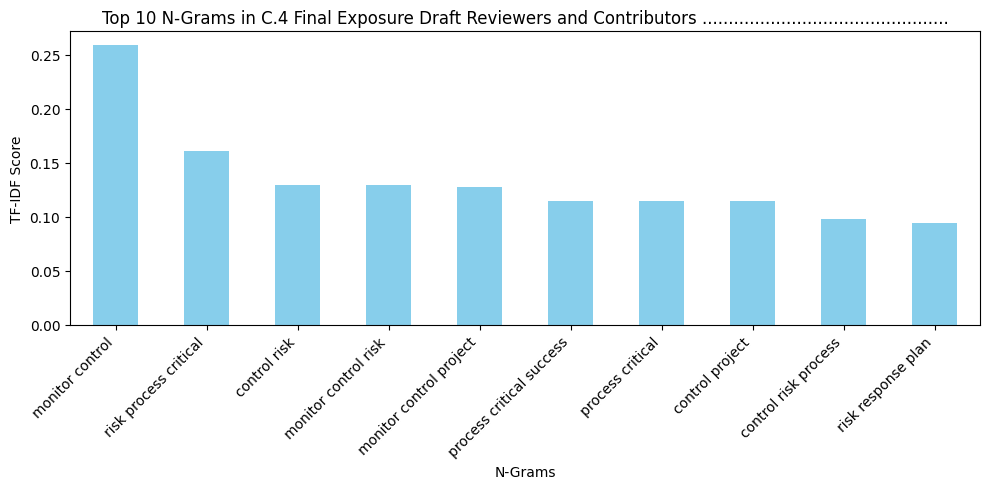

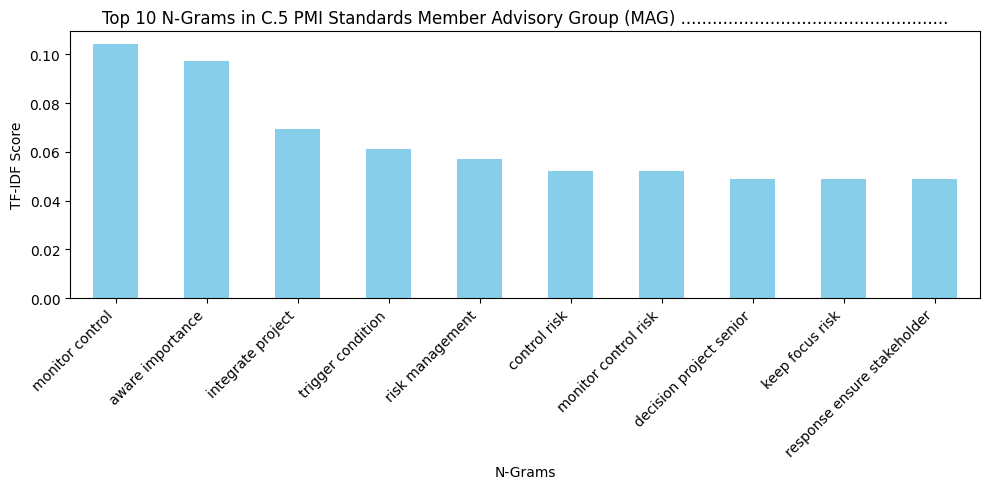

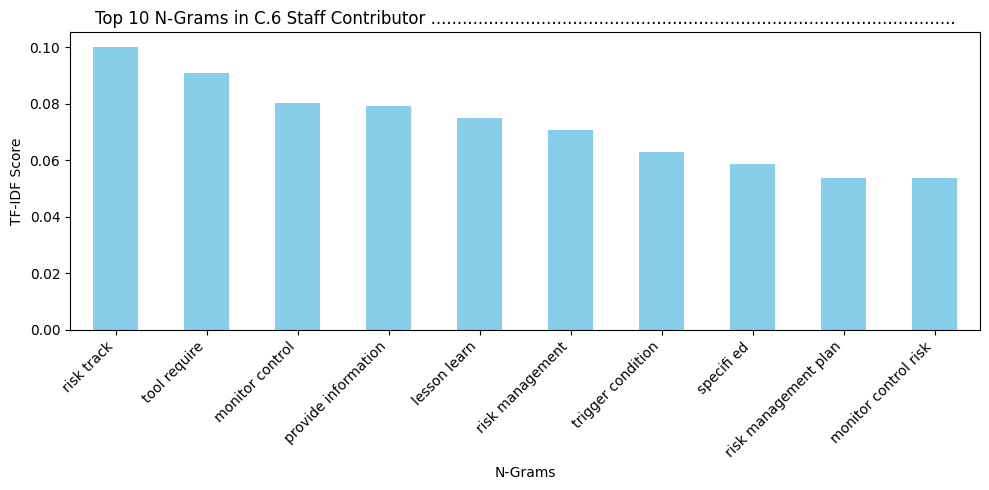

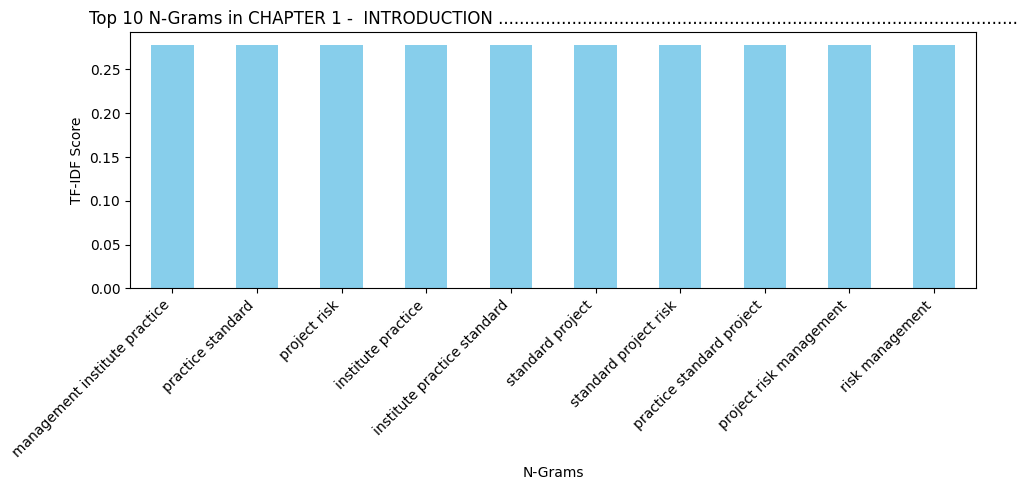

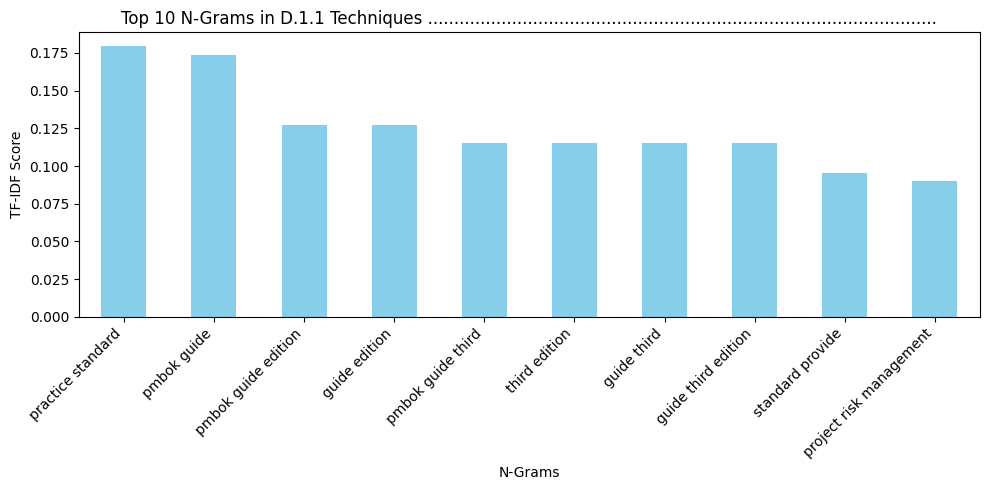

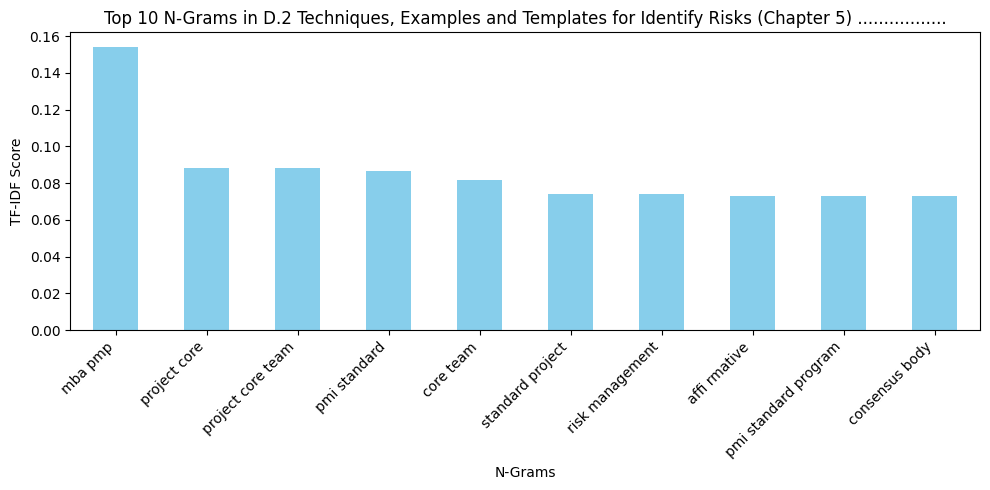

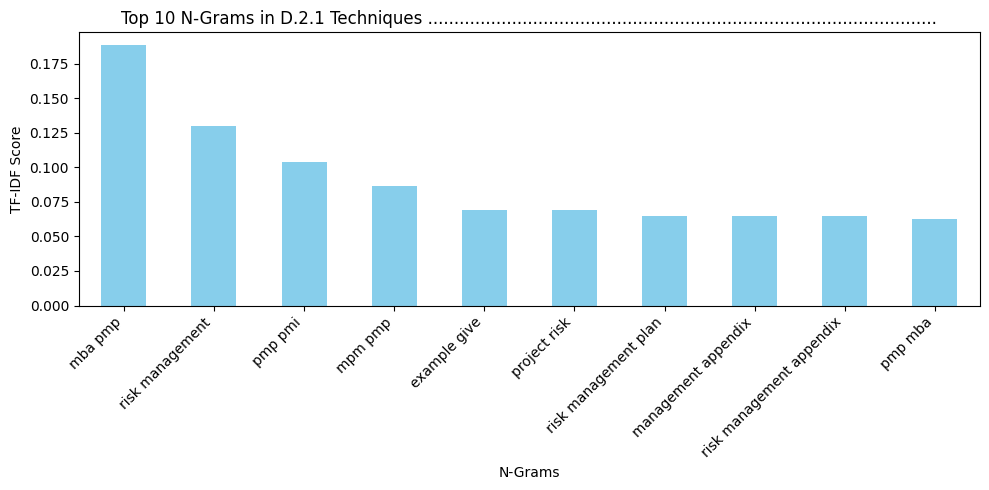

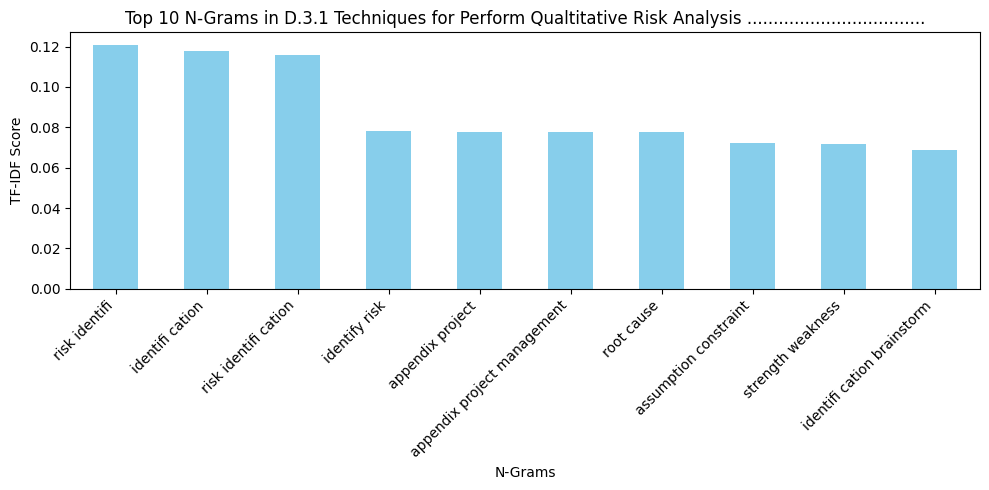

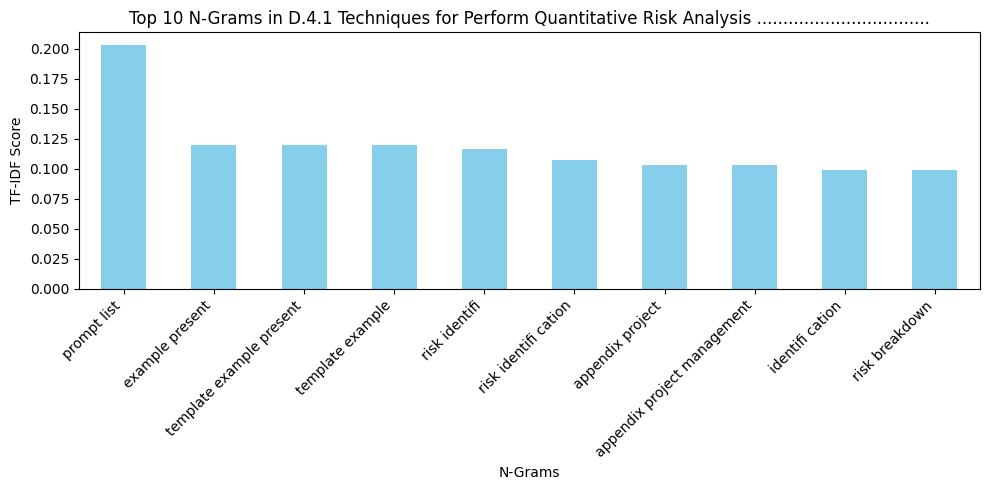

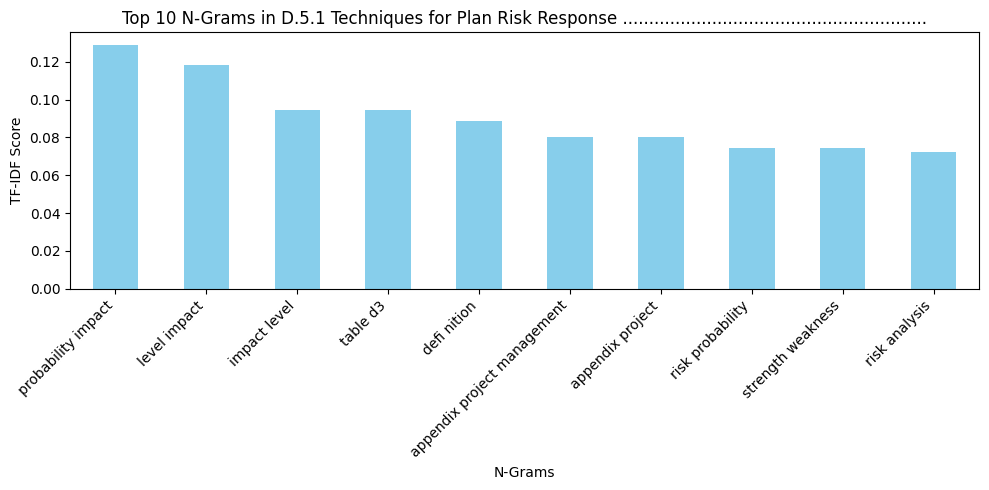

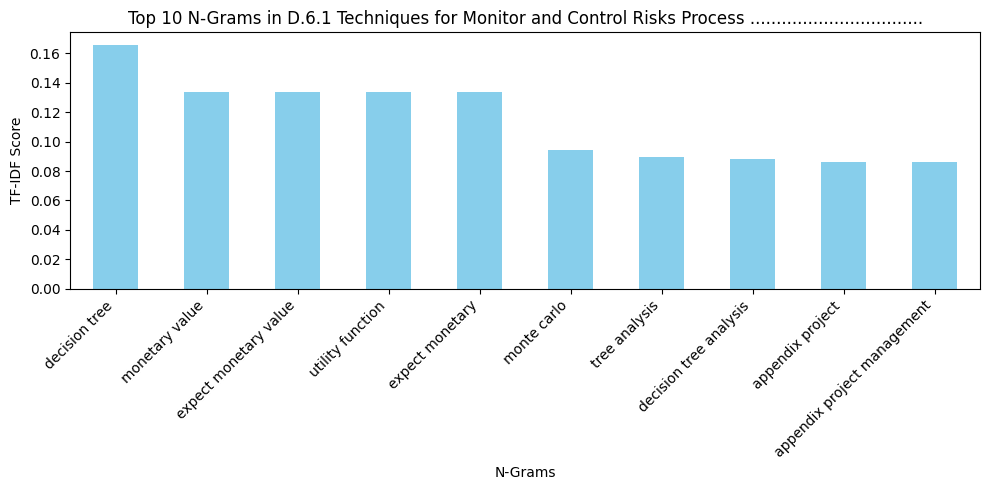

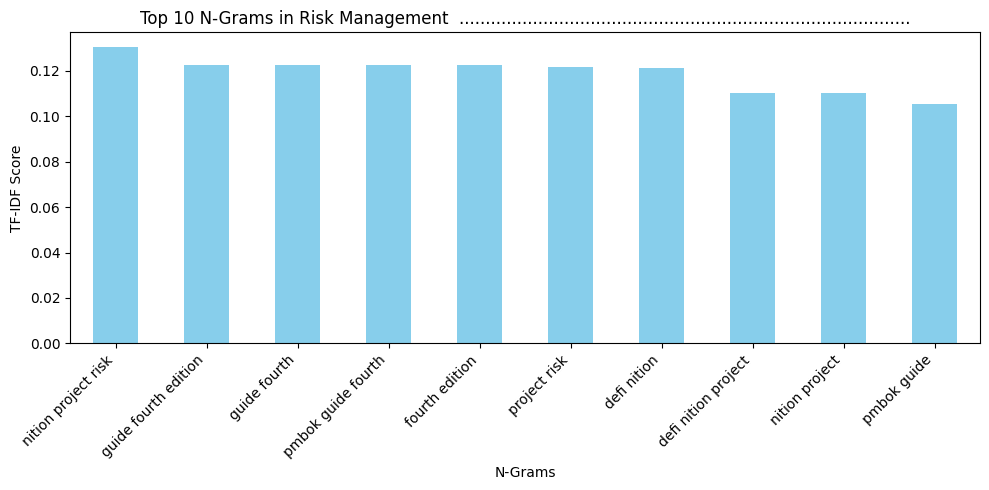

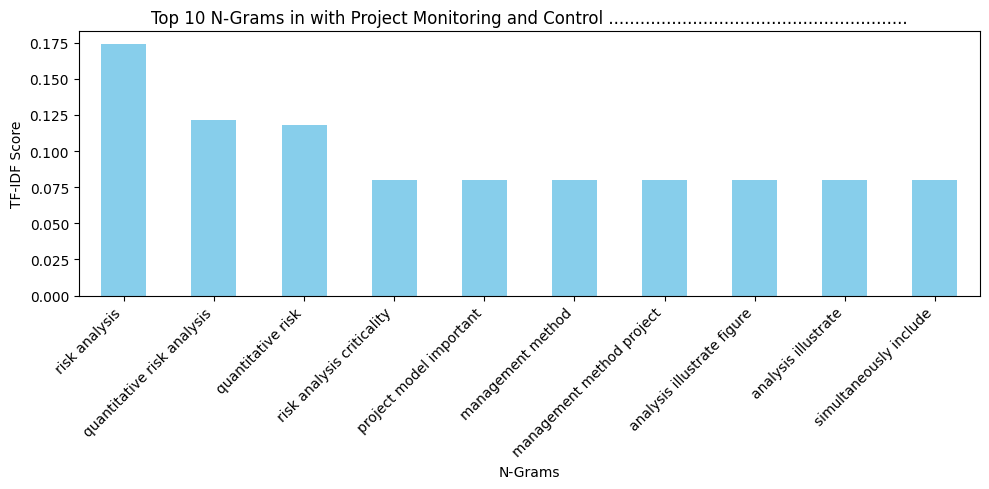

In [29]:
import matplotlib.pyplot as plt

def visualize_ngrams_for_chapter(tfidf_df, chapter, top_n=10):
    """Visualize the top N-Grams for a specific chapter using a bar chart."""
    # Get the top N N-Grams based on their TF-IDF score for the chapter
    top_ngrams = tfidf_df.loc[chapter].sort_values(ascending=False).head(top_n)

    # Plot the N-Grams with their TF-IDF scores
    plt.figure(figsize=(10, 5))
    top_ngrams.plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} N-Grams in {chapter}')
    plt.ylabel('TF-IDF Score')
    plt.xlabel('N-Grams')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage: Visualize the top N-Grams for a specific chapter
for chapter in tfidf_df.index:
    visualize_ngrams_for_chapter(tfidf_df, chapter, top_n=10)


In [30]:
def extract_svo(sentence):
    """Extract subject-verb-object relationships from a sentence."""
    doc = nlp(sentence)
    relations = []

    for token in doc:
        if token.dep_ == "ROOT":  # Main verb of the sentence
            subject = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]  # Subject
            objects = [w for w in token.rights if w.dep_ in ("dobj", "attr", "prep")]  # Object
            if subject and objects:
                relations.append((subject[0].lemma_, token.lemma_, objects[0].lemma_))  # (subject, verb, object)

    return relations

# Extract the SVO relationships for all sentences
svo_relations = []
for sentence in df_sentences['Processed Sentence']:
    svo_relations.extend(extract_svo(sentence))

# Display some extracted SVOs
print("Sample SVO relations:", svo_relations[:5])

Sample SVO relations: [('e', 'customercare', 'internet'), ('journal', 'register', 'inc'), ('+1', 'book.order', 'america'), ('work', 'reproduce', 'without'), ('pmi', 'contain', 'herein')]


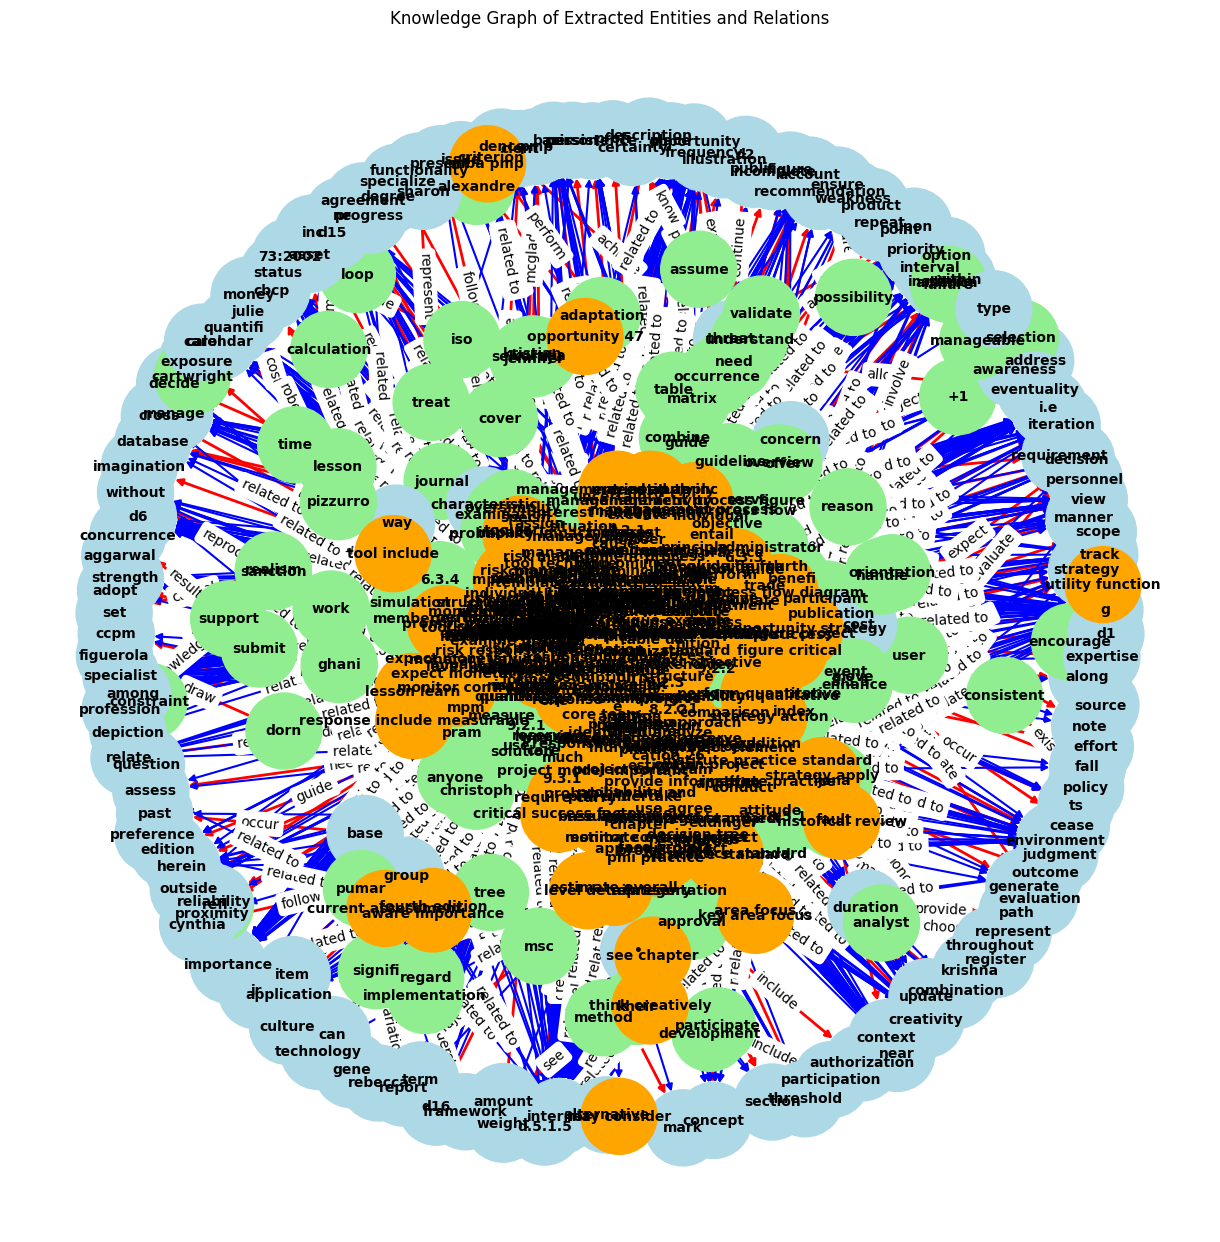

In [31]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on SVO relations
for subject, verb, obj in svo_relations:
    G.add_node(subject, type='entity', color='lightgreen')
    G.add_node(obj, type='entity', color='lightblue')
    G.add_edge(subject, obj, label=verb, color='red', width=2)

# Example: Add top N-Grams as nodes and connect them to related entities
for chapter in tfidf_df.index:
    top_ngrams = tfidf_df.loc[chapter].sort_values(ascending=False).head(5)
    for ngram in top_ngrams.index:
        G.add_node(ngram, type='ngram', color='orange')  # Add N-Gram as node
        # Connect N-Grams to subjects or objects if related
        for subject, _, obj in svo_relations:
            if subject in ngram or obj in ngram:
                G.add_edge(subject, ngram, label="related to", color='blue', width=1.5)
                G.add_edge(ngram, obj, label="related to", color='blue', width=1.5)

# Draw the knowledge graph
pos = nx.spring_layout(G, k=0.5, iterations=200)  # Adjust layout for better visualization

plt.figure(figsize=(12, 12))

# Node colors and edge properties
node_colors = [G.nodes[node].get('color', 'lightgrey') for node in G.nodes]
edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges]
edge_widths = [G.edges[edge].get('width', 1) for edge in G.edges]

# Draw the graph with labels
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=10, font_weight='bold', edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(subj, obj): data['label'] for subj, obj, data in G.edges(data=True)})

plt.title("Knowledge Graph of Extracted Entities and Relations")
plt.show()


In [38]:
pip install plotly


In [39]:
import networkx as nx
import plotly.graph_objects as go

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on SVO relations
for subject, verb, obj in svo_relations:
    G.add_node(subject, type='entity', color='lightgreen')
    G.add_node(obj, type='entity', color='lightblue')
    G.add_edge(subject, obj, label=verb, color='red', width=2)

# Add top N-Grams as nodes and connect them to related entities
for chapter in tfidf_df.index:
    top_ngrams = tfidf_df.loc[chapter].sort_values(ascending=False).head(5)
    for ngram in top_ngrams.index:
        G.add_node(ngram, type='ngram', color='orange')  # Add N-Gram as node
        for subject, _, obj in svo_relations:
            if subject in ngram or obj in ngram:
                G.add_edge(subject, ngram, label="related to", color='blue', width=1.5)
                G.add_edge(ngram, obj, label="related to", color='blue', width=1.5)

# Extract positions for each node using a layout algorithm (spring layout in this case)
pos = nx.spring_layout(G)

# Extract edge traces for Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Create edge traces for Plotly
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Extract node traces for Plotly
node_x = []
node_y = []
node_text = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)  # Display node name
    node_color.append(G.nodes[node].get('color', 'lightgrey'))  # Get node color

# Create node traces for Plotly
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color=node_color,
        size=10,
        line_width=2),
    text=node_text)

# Create the plot layout and combine the traces
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Knowledge Graph of Extracted Entities and Relations',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
               )

# Show the plot
fig.show()


In [41]:
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Print the top 5 most central nodes based on Degree Centrality
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by Degree Centrality:", top_degree_nodes)


Top 5 nodes by Degree Centrality: [('process', 0.10101010101010102), ('management', 0.10101010101010102), ('document', 0.05050505050505051), ('risk', 0.05050505050505051), ('response', 0.05050505050505051)]


In [43]:
# Calculate PageRank
pagerank_scores = nx.pagerank(G)

# Print the top 5 nodes by PageRank score
top_pagerank_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by PageRank:", top_pagerank_nodes)


Top 5 nodes by PageRank: [('process', 0.046627242936101244), ('response', 0.03455655834608963), ('management', 0.032227900263472414), ('document', 0.025592958404173624), ('project', 0.025592958404173624)]


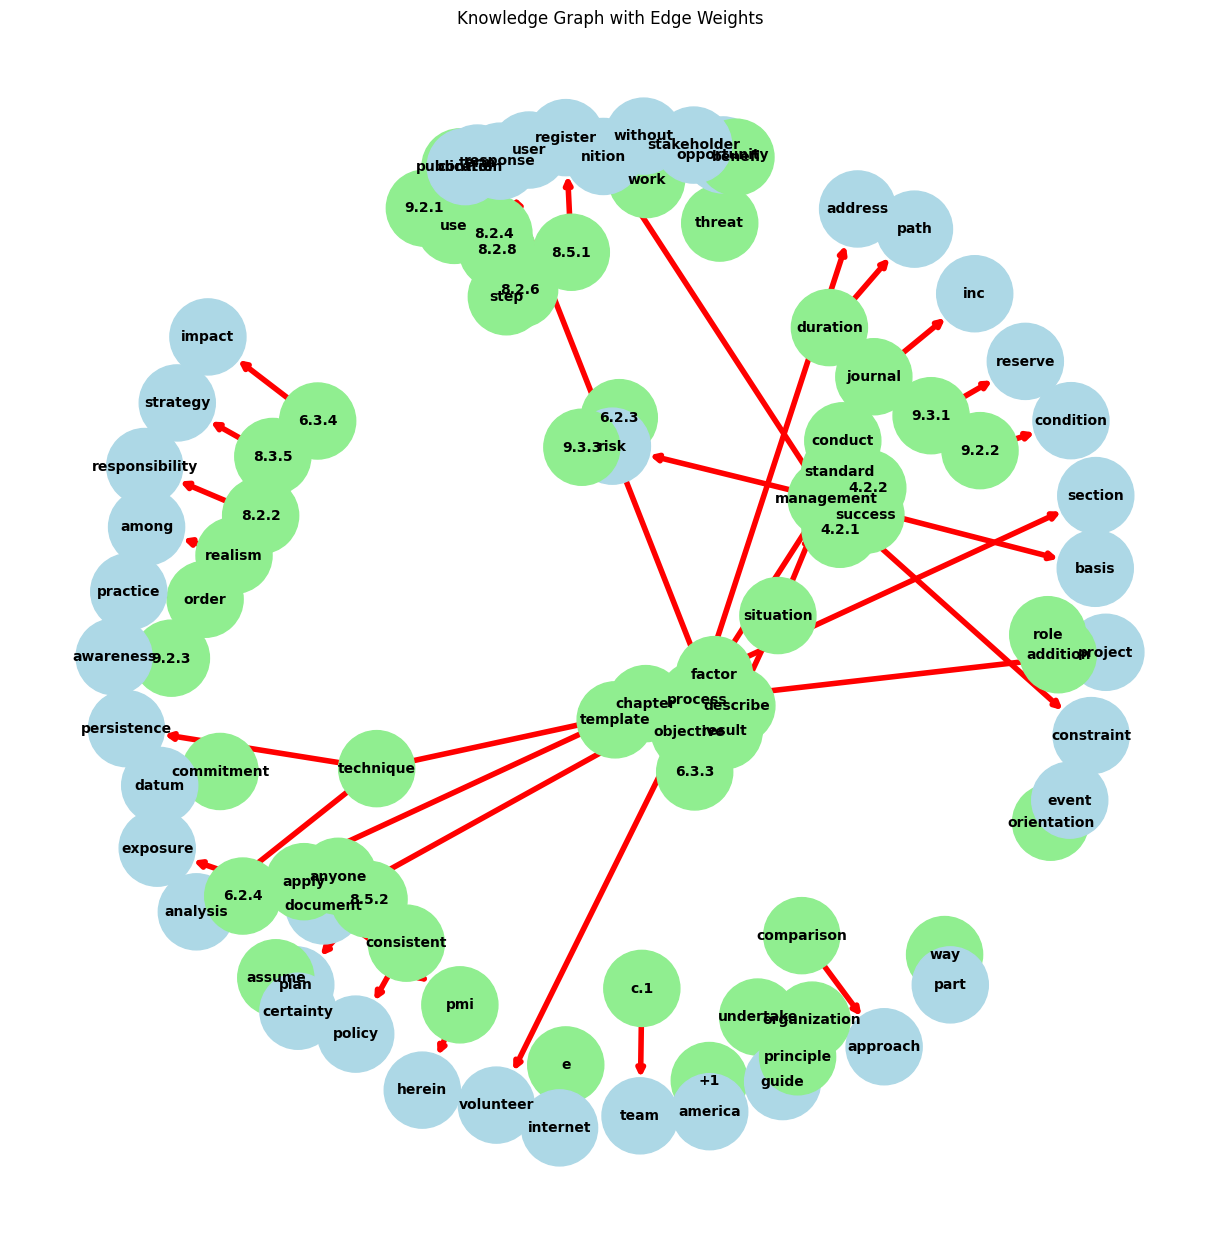

In [47]:
# Visualize with edge widths based on relationship strength (edge weights)
plt.figure(figsize=(12, 12))
edge_widths = [G.edges[edge].get('width', 1) * 2 for edge in G.edges]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=10, font_weight='bold', edge_color=edge_colors, width=edge_widths)
plt.title("Knowledge Graph with Edge Weights")
plt.show()


In [48]:
pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00


Similar entities based on Levenshtein distance (threshold = 3):
Entities: e <-> inc, Levenshtein Distance: 3
Entities: e <-> +1, Levenshtein Distance: 2
Entities: e <-> pmi, Levenshtein Distance: 3
Entities: e <-> user, Levenshtein Distance: 3
Entities: e <-> use, Levenshtein Distance: 2
Entities: e <-> term, Levenshtein Distance: 3
Entities: e <-> c.1, Levenshtein Distance: 3
Entities: e <-> team, Levenshtein Distance: 3
Entities: e <-> step, Levenshtein Distance: 3
Entities: e <-> way, Levenshtein Distance: 3
Entities: e <-> role, Levenshtein Distance: 3
Entities: e <-> deﬁ, Levenshtein Distance: 2
Entities: e <-> set, Levenshtein Distance: 2
Entities: e <-> time, Levenshtein Distance: 3
Entities: e <-> ne, Levenshtein Distance: 1
Entities: e <-> •, Levenshtein Distance: 1
Entities: e <-> view, Levenshtein Distance: 3
Entities: e <-> ed, Levenshtein Distance: 1
Entities: e <-> need, Levenshtein Distance: 3
Entities: e <-> note, Levenshtein Distance: 3
Entities: e <-> base, Levenshtei

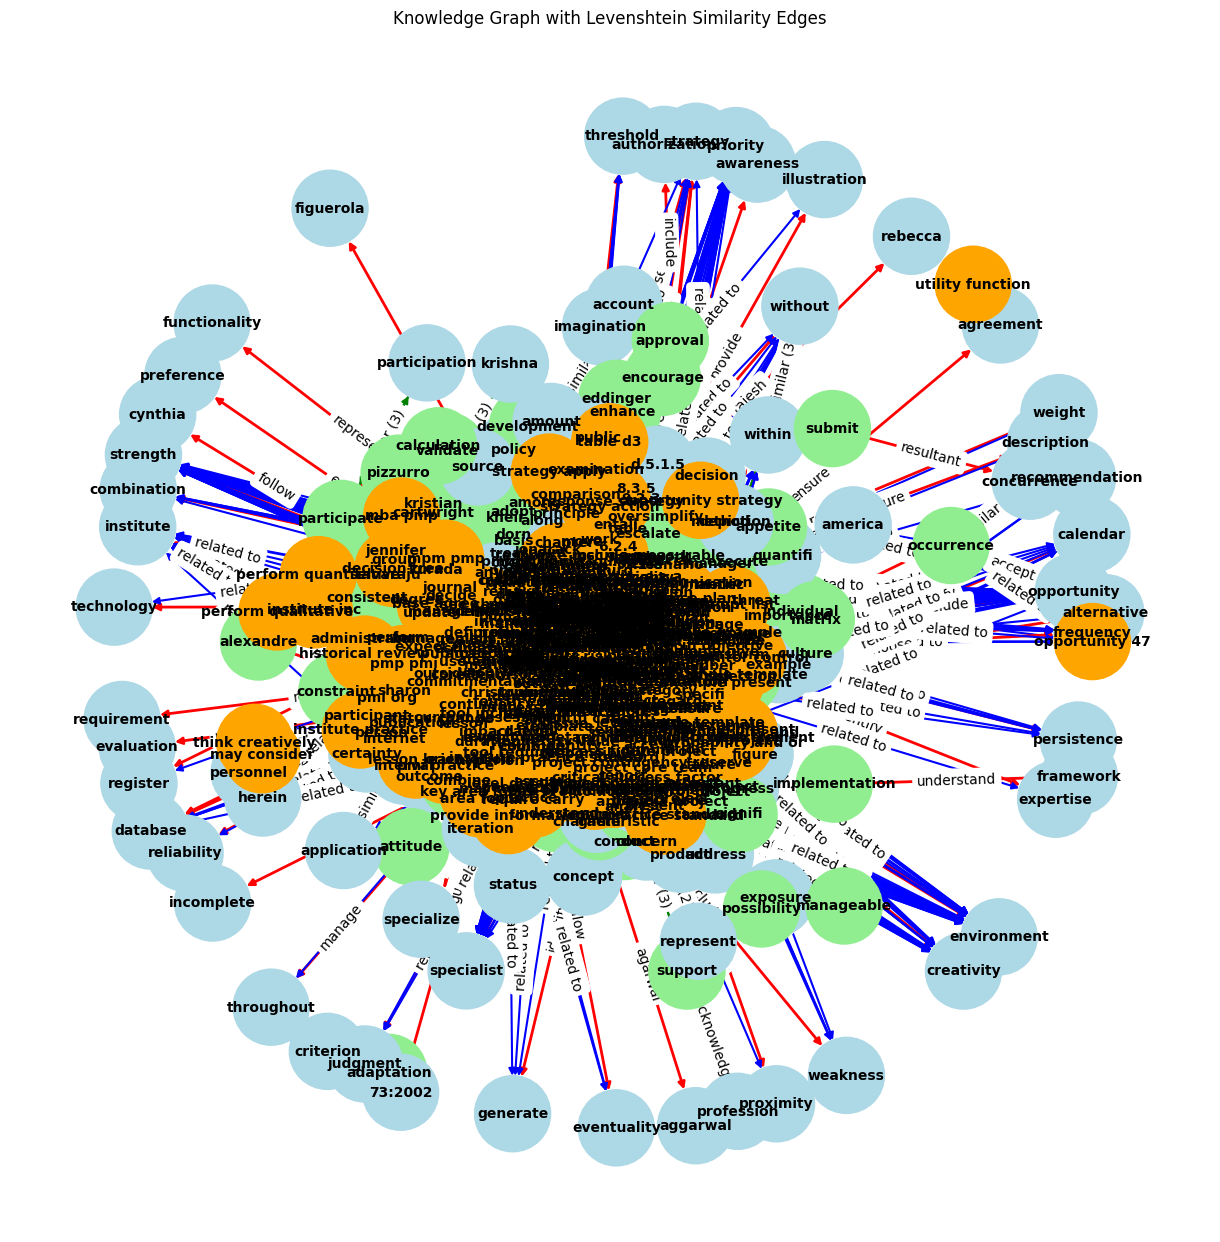

In [49]:
import Levenshtein as lev
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on SVO relations (your existing code)
for subject, verb, obj in svo_relations:
    G.add_node(subject, type='entity', color='lightgreen')
    G.add_node(obj, type='entity', color='lightblue')
    G.add_edge(subject, obj, label=verb, color='red', width=2)

# Add top N-Grams as nodes and connect them to related entities (your existing code)
for chapter in tfidf_df.index:
    top_ngrams = tfidf_df.loc[chapter].sort_values(ascending=False).head(5)
    for ngram in top_ngrams.index:
        G.add_node(ngram, type='ngram', color='orange')
        for subject, _, obj in svo_relations:
            if subject in ngram or obj in ngram:
                G.add_edge(subject, ngram, label="related to", color='blue', width=1.5)
                G.add_edge(ngram, obj, label="related to", color='blue', width=1.5)

# Calculate Levenshtein distances between nodes
lev_distances = {}

# Loop through pairs of nodes in the graph and calculate the Levenshtein distance
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:  # Avoid comparing the same node
            distance = lev.distance(node1, node2)
            if distance <= 3:  # Set a threshold (3 in this case)
                lev_distances[(node1, node2)] = distance

# Display similar entities based on Levenshtein distance
print("Similar entities based on Levenshtein distance (threshold = 3):")
for (n1, n2), dist in lev_distances.items():
    print(f"Entities: {n1} <-> {n2}, Levenshtein Distance: {dist}")

# Add edges between similar nodes
for (node1, node2), distance in lev_distances.items():
    G.add_edge(node1, node2, label=f"similar ({distance})", color='green', width=1.5)

# Visualize the graph with similarity edges
pos = nx.spring_layout(G, k=0.5, iterations=200)

plt.figure(figsize=(12, 12))

# Node colors and edge properties
node_colors = [G.nodes[node].get('color', 'lightgrey') for node in G.nodes]
edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges]
edge_widths = [G.edges[edge].get('width', 1) for edge in G.edges]

# Draw the graph with similarity edges
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=10, font_weight='bold', edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(subj, obj): data['label'] for subj, obj, data in G.edges(data=True)})

plt.title("Knowledge Graph with Levenshtein Similarity Edges")
plt.show()


In [58]:
def inspect_pdf_text(pdf_path, start_page=0, end_page=5):
    """Inspect the raw text of the specified page range of the PDF."""
    with fitz.open(pdf_path) as doc:
        for page_num in range(start_page, end_page):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            print(f"\n--- Page {page_num + 1} ---\n{text}\n")

# Inspect the first few pages
inspect_pdf_text(pdf_path, start_page=0, end_page=6)



--- Page 1 ---
 Project Management Institute 
 PRACTICE STANDARD 
FOR PROJECT RISK MANAGEMENT 



--- Page 2 ---
 ISBN: 978-1-933890-38-8 
 Published by: 
 
Project Management Institute, Inc. 
 
14 Campus Boulevard 
 
Newtown Square, Pennsylvania 19073-3299 USA. 
 
Phone: +610-356-4600 
 
Fax: +610-356-4647 
 
E-mail: customercare@pmi.org 
 Internet: www.pmi.org 
 ©2009 Project Management Institute, Inc. All rights reserved. 
 “PMI”, the PMI logo, “PMP”, the PMP logo, “PMBOK”, “PgMP”, “Project Management Journal”, “PM Network”, and the PMI 
Today logo are registered marks of Project Management Institute, Inc. The Quarter Globe Design is a trademark of the Project 
Management Institute, Inc. For a comprehensive list of PMI marks, contact the PMI Legal Department. 
 PMI Publications welcomes corrections and comments on its books. Please feel free to send comments on typographical, 
formatting, or other errors. Simply make a copy of the relevant page of the book, mark the error, and send

In [67]:
def inspect_pdf_text(pdf_path, start_page=0, end_page=5):
    """Inspect the raw text of the specified page range of the PDF."""
    with fitz.open(pdf_path) as doc:
        for page_num in range(start_page, end_page):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            print(f"\n--- Page {page_num + 1} ---\n{text}\n")

# Path to your PDF file
pdf_path = '/content/drive/MyDrive/practice-standard-project-risk-management.pdf'

# Inspect the raw text of the first few pages (adjust page range as needed)
inspect_pdf_text(pdf_path, start_page=10, end_page=11)  # For TOF



--- Page 11 ---
©2009 Project Management Institute. Practice Standard for Project Risk Management
 LIST OF FIGURES 
 Figure 1-1. 
Hierarchy of PMI Project Risk Management Resources ....................................................2 
 Figure 1-2. 
Critical Success Factors for Project Risk Management .....................................................6 
 Figure 3-1. 
Project Risk Management Process Flow Diagram ...........................................................17 
 Figure 4-1. 
Key Areas of Focus for the Plan Risk Management Process ...........................................23 
 Figure 5-1. 
Three Perspectives of Risk Identification .........................................................................27 
 Figure 5-2. 
Cause, Risk, and Effect ......................................................................................................29 
 Figure 6-1. 
Building Risk Analysis Credibility ...........................................................................

In [72]:
import fitz  # PyMuPDF
import os
import re

# Create a folder to save extracted images
image_dir = "extracted_images_toc"
os.makedirs(image_dir, exist_ok=True)

def extract_images_from_page(pdf_path, page_num):
    """Extract images from a given page in the PDF."""
    images = []
    with fitz.open(pdf_path) as doc:
        page = doc.load_page(page_num)
        image_list = page.get_images(full=True)
        for img_index, img_info in enumerate(image_list):
            xref = img_info[0]
            base_image = doc.extract_image(xref)
            img_bytes = base_image["image"]
            img_ext = base_image["ext"]
            images.append((img_bytes, img_ext, img_index, page_num))
    return images

def save_image(image_data, image_name):
    """Save the image to the specified directory with the given name."""
    img_bytes, img_ext, _, _ = image_data
    img_path = os.path.join(image_dir, f"{image_name}.{img_ext}")
    with open(img_path, "wb") as img_file:
        img_file.write(img_bytes)
    print(f"Saved image: {img_path}")

# Extract TOC (Table of Contents) using regex pattern (already working)
def extract_toc_text_based(pdf_path, toc_start_page=5, toc_end_page=10):
    """Extract Table of Contents from the text of the PDF."""
    toc_entries = []
    try:
        with fitz.open(pdf_path) as doc:
            for page_num in range(toc_start_page, toc_end_page):
                page = doc.load_page(page_num)
                text = page.get_text("text")
                # Look for lines starting with "CHAPTER <number> - <Chapter Title> .... <Page Number>"
                for line in text.split('\n'):
                    match = re.match(r'(CHAPTER\s+\d+\s*-\s*.+?)(\d+)$', line.strip())
                    if match:
                        chapter_title = match.group(1).strip()
                        chapter_page = int(match.group(2).strip())
                        toc_entries.append((chapter_title, chapter_page))
    except Exception as e:
        print(f"Error reading the PDF file for TOC: {e}")
    return toc_entries

def extract_images_by_toc(pdf_path, toc_entries):
    """Extract images based on TOC chapter page ranges."""
    with fitz.open(pdf_path) as doc:
        total_pages = doc.page_count

        # Extract images for each chapter based on TOC page ranges
        for i, (chapter_title, start_page) in enumerate(toc_entries):
            if i < len(toc_entries) - 1:
                end_page = toc_entries[i + 1][1]  # Next chapter's starting page
            else:
                end_page = total_pages  # Last chapter goes till the end of the document

            # Extract images from each page in the chapter range
            for page_num in range(start_page - 1, end_page - 1):  # PyMuPDF uses 0-indexed pages
                images = extract_images_from_page(pdf_path, page_num)
                for img_index, image_data in enumerate(images):
                    # Clean chapter name for file naming
                    chapter_clean = re.sub(r'[^a-zA-Z0-9_]', '_', chapter_title)
                    image_name = f"{chapter_clean}_page_{page_num + 1}_image_{img_index + 1}"
                    save_image(image_data, image_name)

# Path to your PDF file
pdf_path = '/content/drive/MyDrive/practice-standard-project-risk-management.pdf'

# Step 1: Extract the Table of Contents (TOC) using the method
toc_entries = extract_toc_text_based(pdf_path, toc_start_page=5, toc_end_page=10)
print("Extracted TOC:", toc_entries)

# Step 2: Extract images based on TOC chapters
extract_images_by_toc(pdf_path, toc_entries)


Extracted TOC: [('CHAPTER 5 -  IDENTIFY RISKS ................................................................................................', 25), ('CHAPTER 6 -  PERFORM QUALITATIVE RISK ANALYSIS ..........................................................', 31), ('CHAPTER 7 -  PERFORM QUANTITATIVE RISK ANALYSIS .......................................................', 37), ('CHAPTER 8 -  PLAN RISK RESPONSES ...................................................................................', 43), ('CHAPTER 9 -  MONITOR AND CONTROL RISKS .......................................................................', 51)]
Saved image: extracted_images_toc/CHAPTER_5____IDENTIFY_RISKS__________________________________________________________________________________________________page_29_image_1.png
Saved image: extracted_images_toc/CHAPTER_6____PERFORM_QUALITATIVE_RISK_ANALYSIS____________________________________________________________page_35_image_1.png
Saved image: extracted_images_toc/CHA